## Analysis of wafer thickness measurements

This utility takes raw thickness measurement data (such as ellipsometry) of a wafer and computes mean, sigma and physical correlation length for the thickness variations.

In this example, the variations are measured in nanometers.

1. Import python dependencies and specify functions
2. Read out the measurement data, and process it against a nominal thickness value, in this case, 200 nm
3. select either the whole sample or process a section from the total sample
4. 


<img src="./images/wafer_map.png?gx" style="width: 70%; float:left"/>

In [198]:
"""
Import dependencies
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib, random, time, warnings, os, sys, csv, warnings
from scipy.io import loadmat
from copy import deepcopy
from scipy import interpolate
from tqdm import tqdm, tqdm_notebook
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution


font = {'family' : 'arial',
        'weight': 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

# functions used throughout the program

#function to plot the raw data and the fit curve
def ModelAndScatterPlot(xData, yData, xscale, yscale, graphWidth=800, graphHeight=600, plot='y'):

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)
    
    ydiff = np.diff(yModel)/np.diff(xModel)
    if(np.argmin(ydiff>=0.15)>0): #TOLERANCE
        fit = 1
    else:
        fit = 0
    if(plot=='y'):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
        axes = f.add_subplot(111)
        # first the raw data as a scatter plot
        axes.plot((xData*(xscale[1]-xscale[0])) + xscale[0], (yData*(yscale[1]-yscale[0])) + yscale[0],  'D')    
        # now the model as a line plot
        axes.plot((xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0])
        axes.plot((xModel[1:]*(xscale[1]-xscale[0])) + xscale[0], ydiff)
        axes.set_xlabel('X Data') # X axis data label
        axes.set_ylabel('Y Data') # Y axis data label
        plt.show()
        plt.close('all') # clean up after using pyplot
    
    return (xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0], fit

# sigmoid function
def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)

# function to define initial parameters for the sigmoid curve
def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # seach bounds for a
    parameterBounds.append([minX, maxX]) # seach bounds for b
    parameterBounds.append([minX, maxY]) # seach bounds for Offset

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x
    

In [234]:
#Define nominal thickness and read thickness measurement data

nominal_w = 220 #in nm
avg_h = [[],[]]
filename ='./ANT_waferpro/WaferPro_FineScan_50mm.csv'

tot_hx_array = []
tot_hy_array = []
tot_dh = []

count = 0
#filename = 'data_faster_uniform(div=20).csv'
with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        
        if(count>0):
            tot_hx_array.append(float(row[0])*1e3)
            tot_hy_array.append(float(row[1])*1e3)
            tot_dh.append(float(row[2])-nominal_w)
        else:
            print(row)
            count+=1



['Die x (mm)', 'Die y (mm)', 'Site 1 Layer 1 Thickness (nm)', 'Site 1 Layer 2 Thickness (nm)', 'Site 1 Original Point Order']


<Figure size 432x288 with 0 Axes>

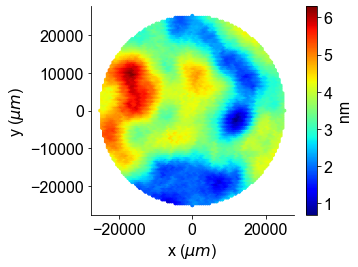

In [200]:
fig = plt.figure()
ogfig = plt.figure()
fig = plt.subplot(111)
plt.scatter( tot_hx_array, tot_hy_array,  c = tot_dh, s=10,  cmap = 'jet', marker = 'h')
ogfig.set_size_inches(5.25, 4)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'y ($\mu m$)')
plt.tight_layout()
colorbar = plt.colorbar()
colorbar.set_label('nm')
plt.tight_layout()
plt.savefig('./images/wafer_map.png', dpi=300)
plt.show()


### Select a die sample from the wafer map

Specify a virtual die size ($\mu m$) and origin ($\mu m$)

<img src="./images/slice_map.png?a" style="width: 70%; float: left"/>


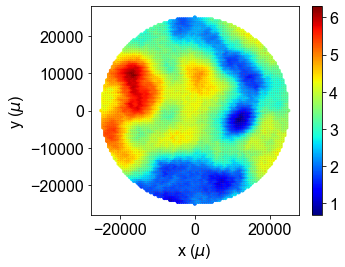

3.365302073089701 1.0769640109348402


In [274]:
#select a wafer slice

origin_places = [-13500, -4500, 4500, 13500] #

origin = [0, origin_places[2]]
xspan = 300000
yspan = 90000
tot_hx_arr = []
tot_hy_arr = []
all_dh = []
for i in range(len(tot_hx_array)):
    temp_x = tot_hx_array[i]
    temp_y = tot_hy_array[i]
    
    if(temp_x >= origin[0]-(xspan/2) and temp_x< origin[0]+(xspan/2)):
        if(temp_y >= origin[1]-(yspan/2) and temp_y< origin[1]+(yspan/2)):
            tot_hx_arr.append(temp_x)
            tot_hy_arr.append(temp_y)
            all_dh.append(tot_dh[i])
np.mean(all_dh), np.std(all_dh)
fig = plt.figure()
plt.plot(tot_hx_array, tot_hy_array, 'rx', markersize = .05)
#plt.plot(tot_hx_arr, tot_hy_arr, 'bx', markersize = 1)
plt.scatter( tot_hx_arr, tot_hy_arr,  c = all_dh, s=10,  cmap = 'jet', marker = 'h')
fig.set_size_inches(5.25,4)
plt.colorbar()
plt.tight_layout()
plt.xlabel(r'x ($\mu$)')
plt.ylabel(r'y ($\mu$)')
plt.tight_layout()
#plt.xlim(left=-24495, right=-24485)
#plt.ylim(top=10, bottom = -10)
#plt.savefig('./images/slice_map.png', dpi=300)
plt.show()

print(np.mean(tot_dh), np.std(tot_dh))

### Plot Cumulative Distribution Function (CDF) for the variations

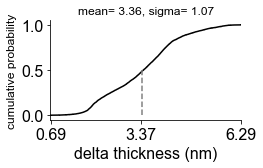

In [275]:
temp_data = all_dh
fig = plt.figure()
h, edges = np.histogram(temp_data, density=False, bins=len(temp_data))
h = np.cumsum(h)/np.cumsum(h).max()
X = edges.repeat(2)[:-1]
y = np.zeros_like(X)
y[1:] = h.repeat(2)
plt.plot(X, y, 'k')
plt.plot([round(np.mean(temp_data),2), round(np.mean(temp_data),2)],[0, 0.5], linestyle='--', color= 'grey')
plt.xlim(left =min(temp_data), right= max(temp_data))
plt.xticks([round(min(temp_data),2), np.mean(temp_data), round(max(temp_data),2)], [round(min(temp_data),2), round(np.mean(temp_data),2), round(max(temp_data),2)])
plt.yticks([0, 0.5, 1])
plt.xlabel('delta thickness (nm)')
plt.ylabel('cumulative probability', fontsize=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

#plt.title('mean = '+str(np.mean(temp_data))[0:5]+' (nm), sigma = '+ str(np.std(temp_data))[0:5]+' (nm)', fontsize = 18)
fig.set_size_inches(1.5*2.625, 2.625)
plt.title('mean= ' +str(np.mean(temp_data))[:4]+', sigma= ' + str(np.std(temp_data))[:4], fontsize=12)
plt.tight_layout()
#plt.savefig('die_mean_sigma.pdf', dpi=600)

In [236]:
#for each pair generate absolute difference between heights

rh_pair = [[], []]
count = 0
for i in tqdm_notebook(range(len(tot_hx_arr))):
    for j in range(i+1,len(tot_hx_arr),1):
        e = np.sqrt((tot_hx_arr[i] - tot_hx_arr[j])**2 + (tot_hy_arr[i] - tot_hy_arr[j])**2)        
        
        #rh = np.sqrt((all_dh[i] - all_dh[j])**2)
        rh = abs(all_dh[i]**2 - all_dh[j]**2)
        
        rh_pair[0].append(e)
        rh_pair[1].append(rh)
        

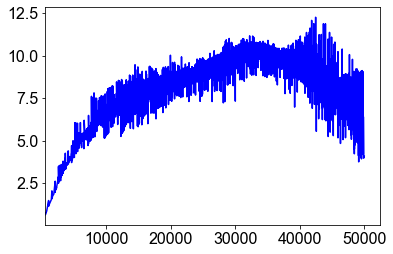

In [237]:
bin_size = 1

#generate limits as arrays
ranges = []
for max_limit in range(0, int(max(rh_pair[0])), bin_size):
    ranges.append([max_limit, max_limit+bin_size,  [], []])

avg_h = [[], []]


#n times add them in the appropriate dictionaries
for i in tqdm_notebook(range(len(rh_pair[0]))):
    each_val = rh_pair[0][i]
    #print(i, len(rh_pair[0]))
    #binary search to find the best match
    left = 0
    right = len(ranges)-1
    while True:
        arr_idx = int(round((left+right)/2))
        if(each_val >= ranges[arr_idx][0] and each_val < ranges[arr_idx][1]):
            break
            
        else:
            if(each_val < ranges[arr_idx][0]):
                if(arr_idx > 0):
                    right = arr_idx -1
                else:
                    break
            elif(each_val >= ranges[arr_idx][1]):
                if(arr_idx < len(ranges)-1):
                    left = arr_idx + 1
                else:
                    break
                    
    ranges[arr_idx][2].append(rh_pair[1][i])
    ranges[arr_idx][3].append(rh_pair[0][i])

    
for i in range(len(ranges)):
        if(len(ranges[i][2])>0):
            avg_h[0].append(np.mean(ranges[i][3]))
            avg_h[1].append(np.mean(ranges[i][2]))
        
#print(max(avg_h))
plt.plot(avg_h[0], avg_h[1], 'b')
#plt.plot([cl,cl], [min(avg_h[1]),max(avg_h[1])], 'y')
#plt.plot(avg_h[0], avg_h_median, 'r',alpha=0.2)
plt.xlim(left = min(avg_h[0]))
plt.show()


Parameters [ 4.5803575   0.2581129  -0.15665808]
RMSE: 0.06791424164652936
R-squared: 0.8918504618945493
DIV 122


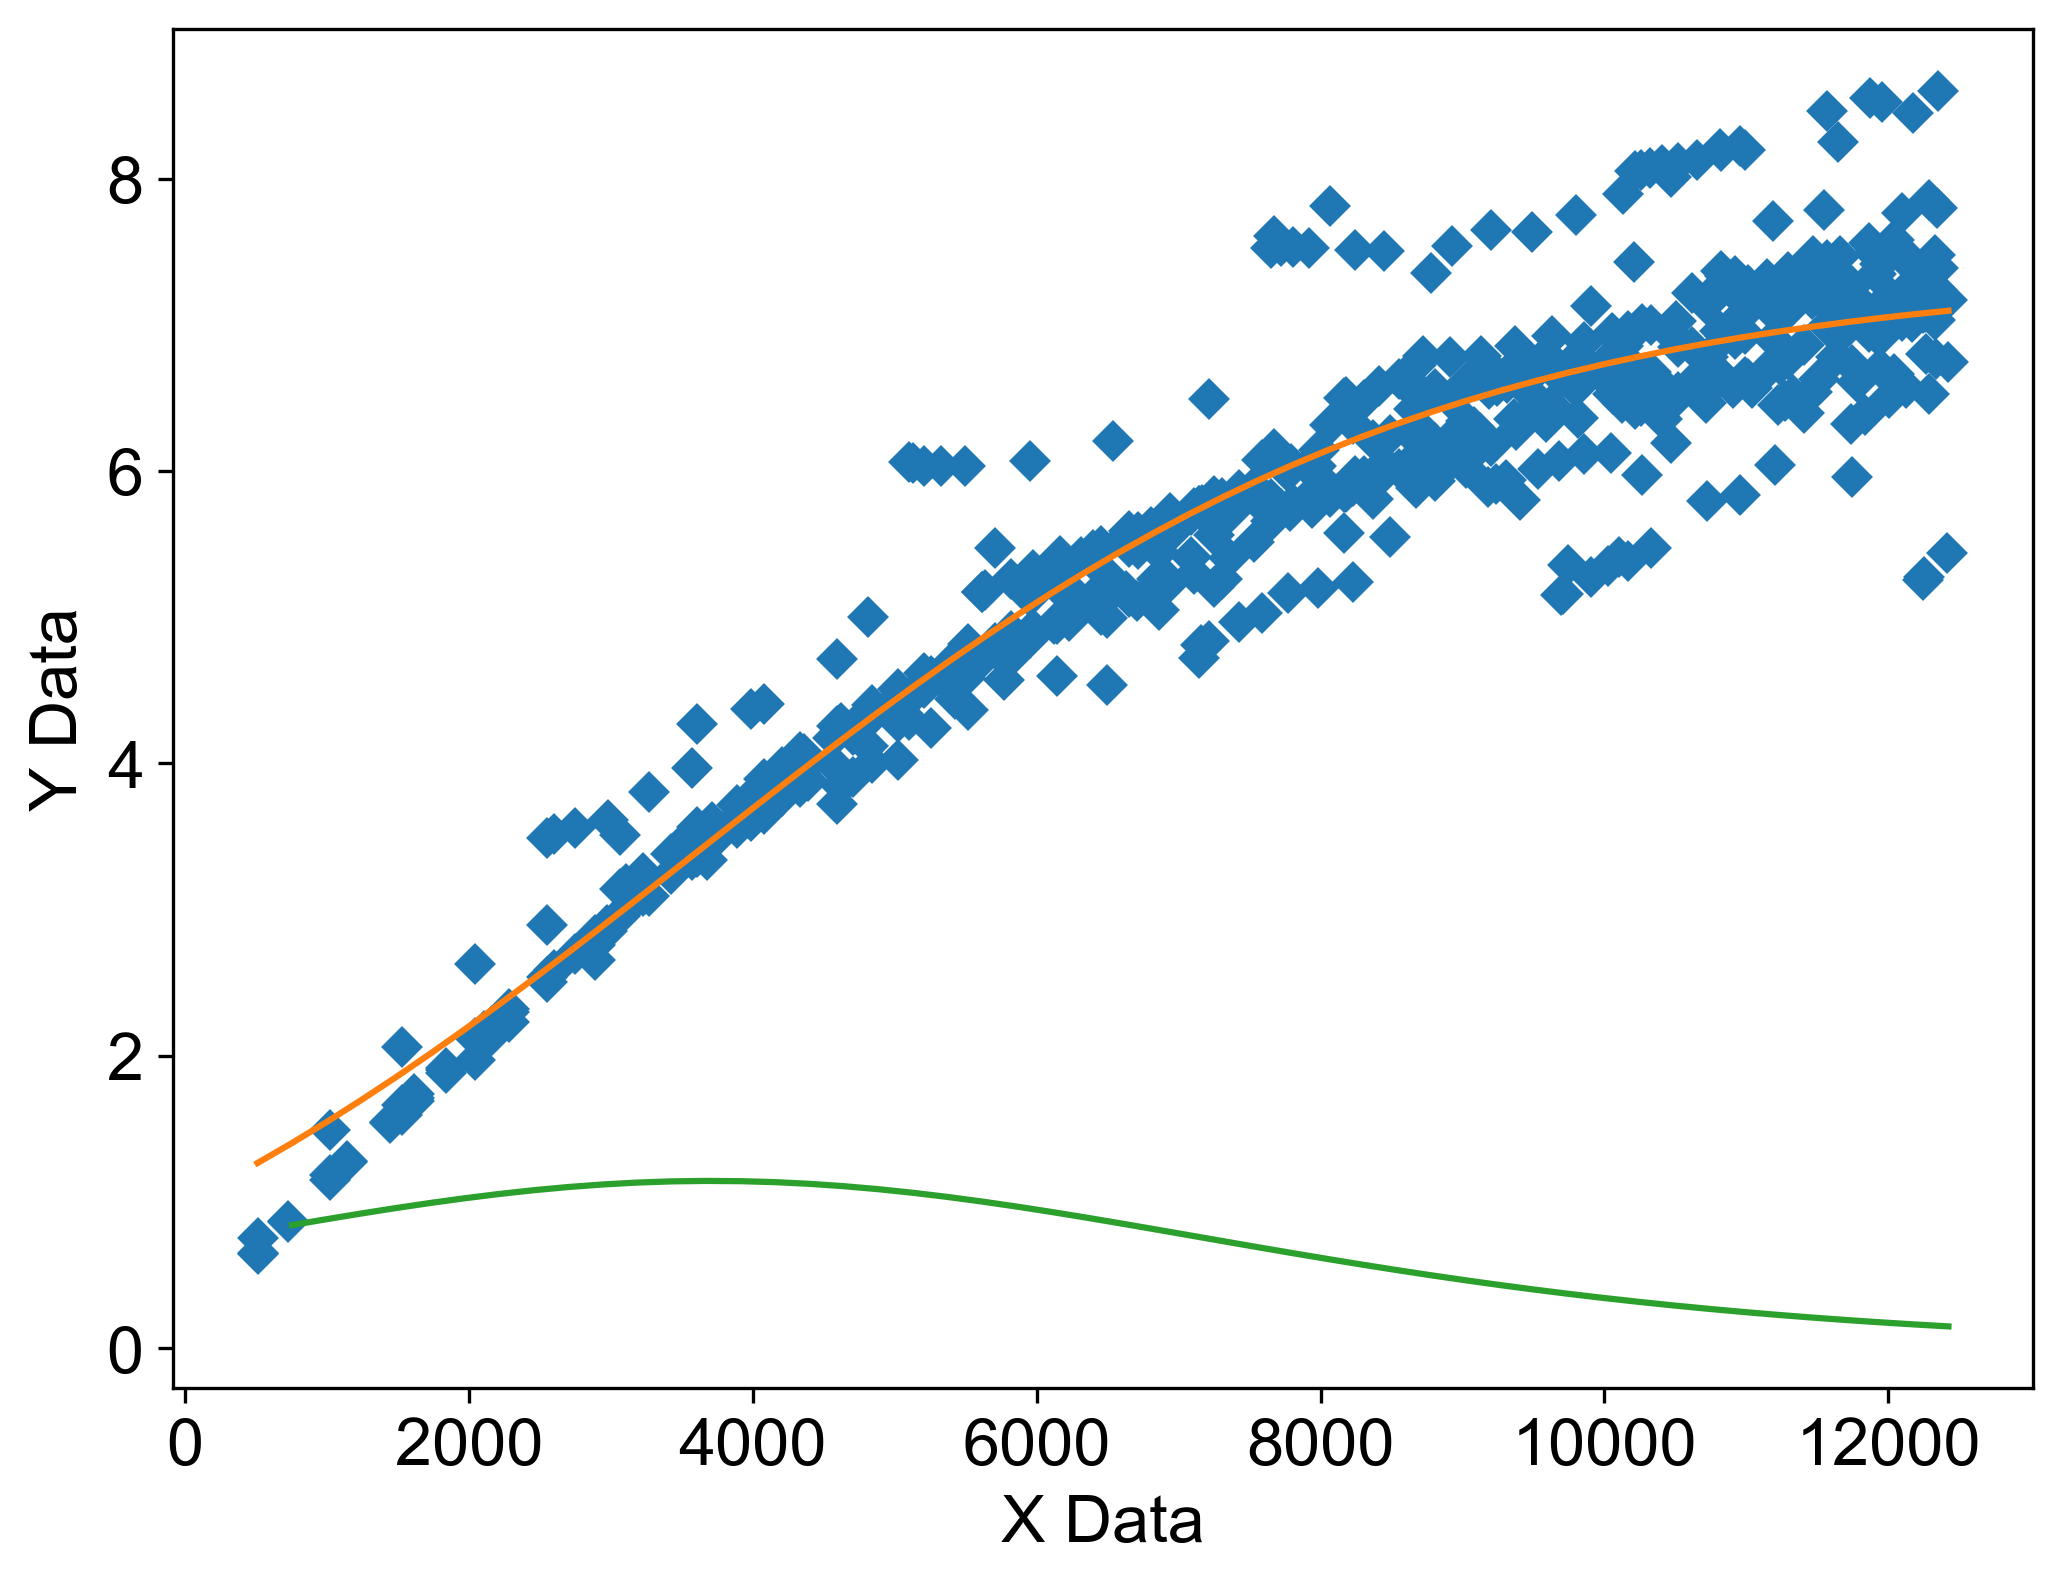


0.9 = 8728.609632397061 , 0.925 = 9321.270163648098 , 0.95 = 10047.231364549449 , 0.975 = 10999.51600456932 , 
0.99 = 11766.714103276163 , 
1 = 12423.627475293897 , 


In [272]:
rsquared_arr = []
div_arr = []


for div in tqdm_notebook(range(1,1000,1)): #RANGE
    divisor = div/10
    xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
    #normalize
    max_x = max(xData)
    min_x = min(xData)
    
    xData = (xData - min_x)/(max_x - min_x)

    yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
    max_y = max(yData)
    min_y = min(yData)
    #scaley = max(yData)
    yData = (yData - min_y)/(max_y - min_y)



    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters()

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

    #print('Parameters', fittedParameters)

    modelPredictions = func(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
    xfit, yfit, tempfit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], graphWidth, graphHeight, 'n')
    if(tempfit ==1):
        rsquared_arr.append(Rsquared)
        div_arr.append(div)
        #print('RMSE:', RMSE)
        #print('R-squared:', Rsquared)
    #print()
    #xfit, yfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)

#idx = len(rsquared_arr)-1#rsquared_arr.index(max(rsquared_arr))
div = div_arr[-1]
divisor = div/10
xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
#normalize
max_x = max(xData)
min_x = min(xData)

xData = (xData - min_x)/(max_x - min_x)

yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
max_y = max(yData)
min_y = min(yData)
#scaley = max(yData)
yData = (yData - min_y)/(max_y - min_y)


# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)
print('DIV', div)
rsquared_arr.append(Rsquared)
div_arr.append(div)
xofit, yofit, fit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], graphWidth, graphHeight)


xfit = (xData*(max_x - min_x)) + min_x
yfit = (modelPredictions*(max_y - min_y)) + min_y

func = interpolate.interp1d(xfit, yfit)
xnew = np.linspace(min(xfit), max(xfit), max(xfit)+1)
ynew = func(xnew)
#plt.plot(xnew, ynew,'b')
maxz_idx = np.argmax(ynew > 0.9 * max(ynew))

#print(xnew[maxz_idx])
print('')
print(0.9, '=',xnew[np.argmax(ynew > 0.9 * max(ynew))],', ', end='')
print(0.925, '=', xnew[np.argmax(ynew > 0.925 * max(ynew))], ', ', end='')
print(0.95, '=',  xnew[np.argmax(ynew > 0.95 * max(ynew))], ', ', end= '')
print(0.975, '=', xnew[np.argmax(ynew > 0.975 * max(ynew))], ', ')
print(0.99, '=', xnew[np.argmax(ynew >= 0.99 * max(ynew))], ', ')
print(1, '=', xnew[np.argmax(ynew >= 1 * max(ynew))], ', ')

(-1964.5008213859037, 30000)

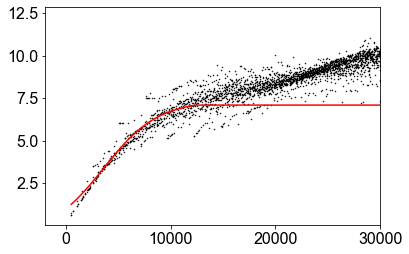

In [271]:
#experimental_avg = avg_h
#avg_h = experimental_avg
avg_h[0][int(len(avg_h[0])/16)]
#print(result_sq_diff)
#plt.axvline(x=10047)
plt.scatter(avg_h[0], avg_h[1], color = 'k', s=0.25)
plt.plot(np.concatenate((xfit, [max(avg_h[0])])), np.concatenate((yfit, [max(yfit)])), 'r')
plt.xlim(right=30000)

In [ ]:
nx_fit = np.concatenate((xnew, np.arange(xnew[-1],max(avg_h[0]),1)))
ny_fit = np.concatenate((ynew, np.ones(np.arange(xnew[-1],max(avg_h[0]),1).size)*ynew[-1]))
plt.scatter(avg_h[0], avg_h[1], color='grey', s = 1)
plt.plot(nx_fit, ny_fit, color = 'orange')
plt.xlabel('r (um)')
plt.ylabel('H[r] (nm)')
plt.title('Estimated CL = %s mm'%(int(xnew[np.argmax(ynew > 0.9 * max(ynew))])/1000))
#0.99 = 7278.90096249262 , 

In [ ]:
places = [-13500, -4500, 4500, 13500]
#origin_arr = [[0, -4500], [0, 4500], [-4500, 0], [4500, 0]]#
origin_arr = [[0, places[0]], [0, places[1]],[0, places[2]],[0, places[3]], [places[0], 0], [places[1], 0], [places[2], 0], [places[3], 0]]  
#origin_arr = [[0,0]]

#xspan_arr = [30000, 30000, 30000, 30000]#
xspan_arr = [30000, 30000,30000,30000, 9000,9000,9000,9000]
#xspan_arr = [300000]

#yspan_arr = [30000, 30000, 30000, 30000]#
yspan_arr = [9000, 9000,9000,9000, 30000, 30000,30000,30000]
#yspan_arr = [300000]

cl_ext_arr = []

for itr_idx in range(len(origin_arr)):
    try:
        # SELECT POINTS
        xspan = xspan_arr[itr_idx]
        yspan = yspan_arr[itr_idx]
        origin = origin_arr[itr_idx]
        tot_hx_arr = []
        tot_hy_arr = []
        all_dh = []
        for i in range(len(tot_hx_array)):
            temp_x = tot_hx_array[i]
            temp_y = tot_hy_array[i]
            if(temp_x >= origin[0]-(xspan/2) and temp_x< origin[0]+(xspan/2)):
                if(temp_y >= origin[1]-(yspan/2) and temp_y< origin[1]+(yspan/2)):
                    tot_hx_arr.append(temp_x)
                    tot_hy_arr.append(temp_y)
                    all_dh.append(tot_dh[i])
        np.mean(all_dh), np.std(all_dh)

        #PLOT POINTS
        fig = plt.figure()
        plt.plot(tot_hx_array, tot_hy_array, 'ro', markersize = 1)
        plt.plot(tot_hx_arr, tot_hy_arr, 'bx', markersize = 1)
        fig.set_size_inches(7,7)
        plt.xlabel(r'x ($\mu$)')
        plt.ylabel(r'y ($\mu$)')
        plt.show()


        #CREATE PAIRS

        rh_pair = [[], []]        
        for i in range(len(tot_hx_arr)):
            for j in range(i+1,len(tot_hx_arr),1):

                e = np.sqrt((tot_hx_arr[i] - tot_hx_arr[j])**2 + (tot_hy_arr[i] - tot_hy_arr[j])**2)        

                rh = np.sqrt((all_dh[i] - all_dh[j])**2)
                #rh = abs(all_dh[i]**2 - all_dh[j]**2)

                rh_pair[0].append(e)
                rh_pair[1].append(rh)

        bin_size = 1

        #generate limits as arrays
        ranges = []
        for max_limit in range(0, int(max(rh_pair[0])), bin_size):
            ranges.append([max_limit, max_limit+bin_size,  [], []])

        avg_h = [[], []]



        #n times add them in the appropriate dictionaries
        for i in range(len(rh_pair[0])):
            each_val = rh_pair[0][i]
            #print(i, len(rh_pair[0]))
            #binary search to find the best match
            left = 0
            right = len(ranges)-1
            while True:
                arr_idx = int(round((left+right)/2))
                if(each_val >= ranges[arr_idx][0] and each_val < ranges[arr_idx][1]):
                    break

                else:
                    if(each_val < ranges[arr_idx][0]):
                        if(arr_idx > 0):
                            right = arr_idx -1
                        else:
                            break
                    elif(each_val >= ranges[arr_idx][1]):
                        if(arr_idx < len(ranges)-1):
                            left = arr_idx + 1
                        else:
                            break

            ranges[arr_idx][2].append(rh_pair[1][i])
            ranges[arr_idx][3].append(rh_pair[0][i])

        for i in range(len(ranges)):
                if(len(ranges[i][2])>0):
                    avg_h[0].append(np.mean(ranges[i][3]))
                    avg_h[1].append(np.mean(ranges[i][2]))

        plt.plot(avg_h[0], avg_h[1], 'b')
        plt.xlim(left = min(avg_h[0]))
        plt.show()

        graphWidth = 800
        graphHeight = 600

        ##########################################################
        # graphics output section
        def ModelAndScatterPlot(xData, yData, xscale, yscale, graphWidth, graphHeight, plot='y'):


            # create data for the fitted equation plot
            xModel = numpy.linspace(min(xData), max(xData))
            yModel = func(xModel, *fittedParameters)

            ydiff = np.diff(yModel)/np.diff(xModel)
            if(np.argmin(ydiff>=0.1)>0):
                fit = 1
            else:
                fit = 0
            if(plot=='y'):
                f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
                axes = f.add_subplot(111)
                #xData = xData*xscale
                #yData=  yData*yscale
                # first the raw data as a scatter plot
                axes.plot(xData*xscale, yData*yscale,  'D')    
                # now the model as a line plot
                axes.plot(xModel*xscale, yModel*yscale)
                axes.plot(xModel[1:]*xscale, ydiff)

                axes.set_xlabel('X Data') # X axis data label
                axes.set_ylabel('Y Data') # Y axis data label

                plt.show()
                plt.close('all') # clean up after using pyplot

            return xModel*xscale, yModel*yscale, fit


        def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
            return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


        # function for genetic algorithm to minimize (sum of squared error)
        def sumOfSquaredError(parameterTuple):
            warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
            val = func(xData, *parameterTuple)
            return numpy.sum((yData - val) ** 2.0)


        def generate_Initial_Parameters():
            # min and max used for bounds
            maxX = max(xData)
            minX = min(xData)
            maxY = max(yData)
            minY = min(yData)

            parameterBounds = []
            parameterBounds.append([minX, maxX]) # seach bounds for a
            parameterBounds.append([minX, maxX]) # seach bounds for b
            parameterBounds.append([minX, maxY]) # seach bounds for Offset

            # "seed" the numpy random number generator for repeatable results
            result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
            return result.x

        rsquared_arr = []
        div_arr = []


        for div in range(19,201,1):
            divisor = div/10
            xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
            scalex = max(xData)
            xData = xData/scalex

            yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
            scaley = max(yData)
            yData = yData/scaley



            # generate initial parameter values
            geneticParameters = generate_Initial_Parameters()

            # curve fit the test data
            fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

            #print('Parameters', fittedParameters)

            modelPredictions = func(xData, *fittedParameters) 

            absError = modelPredictions - yData

            SE = numpy.square(absError) # squared errors
            MSE = numpy.mean(SE) # mean squared errors
            RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
            Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
            xfit, yfit, tempfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight, 'n')
            if(tempfit ==1):
                rsquared_arr.append(Rsquared)
                div_arr.append(div)
                #print('RMSE:', RMSE)
                #print('R-squared:', Rsquared)
            #print()
            #xfit, yfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)

        #idx = rsquared_arr.index(max(rsquared_arr))
        div = div_arr[-1]#idx]
        divisor = div/10
        xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
        scalex = max(xData)
        xData = xData/scalex
        yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
        scaley = max(yData)
        yData = yData/scaley



        # generate initial parameter values
        geneticParameters = generate_Initial_Parameters()

        # curve fit the test data
        fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

        print('Parameters', fittedParameters)

        modelPredictions = func(xData, *fittedParameters) 

        absError = modelPredictions - yData

        SE = numpy.square(absError) # squared errors
        MSE = numpy.mean(SE) # mean squared errors
        RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
        print('RMSE:', RMSE)
        print('R-squared:', Rsquared)
        print('DIV', div)
        rsquared_arr.append(Rsquared)
        div_arr.append(div)
        xofit, yofit, fit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)
        xfit = xData*scalex
        yfit = modelPredictions*scaley

        func = interpolate.interp1d(xfit, yfit)
        xnew = np.linspace(min(xfit), max(xfit), max(xfit)+1)
        ynew = func(xnew)
        #plt.plot(xnew, ynew,'b')
        maxz_idx = np.argmax(ynew > 0.9 * max(ynew))

        #print(xnew[maxz_idx])
        
        print(0.9, '=',xnew[np.argmax(ynew > 0.9 * max(ynew))],', ', end='')
        print(0.925, '=', xnew[np.argmax(ynew > 0.925 * max(ynew))], ', ', end='')
        print(0.95, '=',  xnew[np.argmax(ynew > 0.95 * max(ynew))], ', ', end= '')
        print(0.975, '=', xnew[np.argmax(ynew > 0.975 * max(ynew))], ', ')

        cl_ext_arr.append([itr_idx, xnew[np.argmax(ynew >= 0.9 * max(ynew))], xnew[np.argmax(ynew >= 0.925 * max(ynew))], xnew[np.argmax(ynew >= 0.95 * max(ynew))], xnew[np.argmax(ynew >= 0.975 * max(ynew))], xnew[np.argmax(ynew >= 0.99 * max(ynew))]])

    except Exception as e:
        pass

In [ ]:
places = [-13500, -4500, 4500, 13500]
#origin_arr =  [[0, places[0]], [0, places[1]],[0, places[2]],[0, places[3]], [places[0], 0], [places[1], 0], [places[2], 0], [places[3], 0]]  
#xspan_arr = [30000, 30000,30000,30000, 9000,9000,9000,9000]
#yspan_arr = [9000, 9000,9000,9000, 30000, 30000,30000,30000]

ocl_ext_arr = []

for itr_idx in range(len(origin_arr)):
    try:
        # SELECT POINTS
        xspan = xspan_arr[itr_idx]
        yspan = yspan_arr[itr_idx]
        origin = origin_arr[itr_idx]
        tot_hx_arr = []
        tot_hy_arr = []
        all_dh = []
        for i in range(len(tot_hx_array)):
            temp_x = tot_hx_array[i]
            temp_y = tot_hy_array[i]
            if(temp_x >= origin[0]-(xspan/2) and temp_x< origin[0]+(xspan/2)):
                if(temp_y >= origin[1]-(yspan/2) and temp_y< origin[1]+(yspan/2)):
                    tot_hx_arr.append(temp_x)
                    tot_hy_arr.append(temp_y)
                    all_dh.append(tot_dh[i])
        np.mean(all_dh), np.std(all_dh)

        #PLOT POINTS
        fig = plt.figure()
        plt.plot(tot_hx_array, tot_hy_array, 'ro', markersize = 1)
        plt.plot(tot_hx_arr, tot_hy_arr, 'bx', markersize = 1)
        fig.set_size_inches(7,7)
        plt.xlabel(r'x ($\mu$)')
        plt.ylabel(r'y ($\mu$)')
        plt.show()


        #CREATE PAIRS

        rh_pair = [[], []]        
        for i in range(len(tot_hx_arr)):
            for j in range(i+1,len(tot_hx_arr),1):

                e = np.sqrt((tot_hx_arr[i] - tot_hx_arr[j])**2 + (tot_hy_arr[i] - tot_hy_arr[j])**2)        

                #rh = np.sqrt((all_dh[i] - all_dh[j])**2)
                rh = abs(all_dh[i]**2 - all_dh[j]**2)

                rh_pair[0].append(e)
                rh_pair[1].append(rh)

        bin_size = 1

        #generate limits as arrays
        ranges = []
        for max_limit in range(0, int(max(rh_pair[0])), bin_size):
            ranges.append([max_limit, max_limit+bin_size,  [], []])

        avg_h = [[], []]



        #n times add them in the appropriate dictionaries
        for i in range(len(rh_pair[0])):
            each_val = rh_pair[0][i]
            #print(i, len(rh_pair[0]))
            #binary search to find the best match
            left = 0
            right = len(ranges)-1
            while True:
                arr_idx = int(round((left+right)/2))
                if(each_val >= ranges[arr_idx][0] and each_val < ranges[arr_idx][1]):
                    break

                else:
                    if(each_val < ranges[arr_idx][0]):
                        if(arr_idx > 0):
                            right = arr_idx -1
                        else:
                            break
                    elif(each_val >= ranges[arr_idx][1]):
                        if(arr_idx < len(ranges)-1):
                            left = arr_idx + 1
                        else:
                            break

            ranges[arr_idx][2].append(rh_pair[1][i])
            ranges[arr_idx][3].append(rh_pair[0][i])

        for i in range(len(ranges)):
                if(len(ranges[i][2])>0):
                    avg_h[0].append(np.mean(ranges[i][3]))
                    avg_h[1].append(np.mean(ranges[i][2]))

        plt.plot(avg_h[0], avg_h[1], 'b')
        plt.xlim(left = min(avg_h[0]))
        plt.show()

        graphWidth = 800
        graphHeight = 600

        ##########################################################
        # graphics output section
        def ModelAndScatterPlot(xData, yData, xscale, yscale, graphWidth, graphHeight, plot='y'):


            # create data for the fitted equation plot
            xModel = numpy.linspace(min(xData), max(xData))
            yModel = func(xModel, *fittedParameters)

            ydiff = np.diff(yModel)/np.diff(xModel)
            if(np.argmin(ydiff>=0.05)>0):
                fit = 1
            else:
                fit = 0
            if(plot=='y'):
                f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
                axes = f.add_subplot(111)
                #xData = xData*xscale
                #yData=  yData*yscale
                # first the raw data as a scatter plot
                axes.plot(xData*xscale, yData*yscale,  'D')    
                # now the model as a line plot
                axes.plot(xModel*xscale, yModel*yscale)
                axes.plot(xModel[1:]*xscale, ydiff)

                axes.set_xlabel('X Data') # X axis data label
                axes.set_ylabel('Y Data') # Y axis data label

                plt.show()
                plt.close('all') # clean up after using pyplot

            return xModel*xscale, yModel*yscale, fit


        def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
            return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


        # function for genetic algorithm to minimize (sum of squared error)
        def sumOfSquaredError(parameterTuple):
            warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
            val = func(xData, *parameterTuple)
            return numpy.sum((yData - val) ** 2.0)


        def generate_Initial_Parameters():
            # min and max used for bounds
            maxX = max(xData)
            minX = min(xData)
            maxY = max(yData)
            minY = min(yData)

            parameterBounds = []
            parameterBounds.append([minX, maxX]) # seach bounds for a
            parameterBounds.append([minX, maxX]) # seach bounds for b
            parameterBounds.append([minX, maxY]) # seach bounds for Offset

            # "seed" the numpy random number generator for repeatable results
            result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
            return result.x

        rsquared_arr = []
        div_arr = []


        for div in range(19,201,1):
            divisor = div/10
            xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
            scalex = max(xData)
            xData = xData/scalex

            yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
            scaley = max(yData)
            yData = yData/scaley



            # generate initial parameter values
            geneticParameters = generate_Initial_Parameters()

            # curve fit the test data
            fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

            #print('Parameters', fittedParameters)

            modelPredictions = func(xData, *fittedParameters) 

            absError = modelPredictions - yData

            SE = numpy.square(absError) # squared errors
            MSE = numpy.mean(SE) # mean squared errors
            RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
            Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
            xfit, yfit, tempfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight, 'n')
            if(tempfit ==1):
                rsquared_arr.append(Rsquared)
                div_arr.append(div)
                #print('RMSE:', RMSE)
                #print('R-squared:', Rsquared)
            #print()
            #xfit, yfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)

        #idx = rsquared_arr.index(max(rsquared_arr))
        div = div_arr[-1]#idx]
        divisor = div/10
        xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
        scalex = max(xData)
        xData = xData/scalex
        yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
        scaley = max(yData)
        yData = yData/scaley



        # generate initial parameter values
        geneticParameters = generate_Initial_Parameters()

        # curve fit the test data
        fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

        print('Parameters', fittedParameters)

        modelPredictions = func(xData, *fittedParameters) 

        absError = modelPredictions - yData

        SE = numpy.square(absError) # squared errors
        MSE = numpy.mean(SE) # mean squared errors
        RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
        print('RMSE:', RMSE)
        print('R-squared:', Rsquared)
        print('DIV', div)
        rsquared_arr.append(Rsquared)
        div_arr.append(div)
        xofit, yofit, fit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)
        xfit = xData*scalex
        yfit = modelPredictions*scaley

        func = interpolate.interp1d(xfit, yfit)
        xnew = np.linspace(min(xfit), max(xfit), max(xfit)+1)
        ynew = func(xnew)
        #plt.plot(xnew, ynew,'b')
        maxz_idx = np.argmax(ynew > 0.9 * max(ynew))

        #print(xnew[maxz_idx])
        print('')
        print(0.9, '=',xnew[np.argmax(ynew > 0.9 * max(ynew))],', ', end='')
        print(0.925, '=', xnew[np.argmax(ynew > 0.925 * max(ynew))], ', ', end='')
        print(0.95, '=',  xnew[np.argmax(ynew > 0.95 * max(ynew))], ', ', end= '')
        print(0.975, '=', xnew[np.argmax(ynew > 0.975 * max(ynew))], ', ')

        ocl_ext_arr.append([itr_idx, xnew[np.argmax(ynew >= 0.9 * max(ynew))], xnew[np.argmax(ynew >= 0.925 * max(ynew))], xnew[np.argmax(ynew >= 0.95 * max(ynew))], xnew[np.argmax(ynew >= 0.975 * max(ynew))], xnew[np.argmax(ynew >= 0.99 * max(ynew))]])

    except Exception as e:
        pass

In [ ]:
cl_euclidean = cl_ext_arr
#np.mean([each[1] for each in cl_euclidean])
#cl_square = ocl_ext_arr
#sQUARE = 



#print('ABS', cl_ext_arr)
#print('SQR', ocl_ext_arr)
#ABS [[0, 8916.917161442028, 9536.1316834393, 10293.589447556893, 11285.292705267253, 12080.191347459098]]
#SQR [[0, 8939.957701795414, 9560.132246307412, 10316.629987910279, 11303.533133047016, 12090.751595121068]]

#SQR [8426.274886107707, 11910.552005382919, 9694.866646785173, 18125.556531750735, 6865.348173036539, 8753.326528526653, 7696.113561190738]
#ABS [6329.864609194805, 8831.54642215849, 9328.50561245114, 7385.477206708593, 13413.46819249469, 5145.289777189574, 6556.239613738869, 5568.191808089194]

In [ ]:
## ysq = []
#for each in cl_square:
#    ysq.append(each[-1])
#    ysq.append(each[-1])

#plt.plot([each for each in range(8)], ysq, 'b')
#plt.plot([i for i in range(len(cl_square))], [i[-1] for i in cl_square])
#plt.axhline(12090.75, color = 'b', lineStyle = '--')
#plt.plot([i for i in range(8)], [8426.274886107707, 8426.274886107707, 11910.552005382919, 9694.866646785173, 18125.556531750735, 6865.348173036539, 8753.326528526653, 7696.113561190738], color='b', lineStyle = '-.')


yabs = []
for each in cl_euclidean:
    yabs.append(each[1])
    yabs.append(each[1])

#plt.plot([each for each in range(len(yabs))], yabs, 'g')
plt.plot([i for i in range(len(cl_euclidean))], [i[1] for i in cl_euclidean])
#plt.plot([i for i in range(8)], [6329.864609194805, 8831.54642215849, 9328.50561245114, 7385.477206708593, 13413.46819249469, 5145.289777189574, 6556.239613738869, 5568.191808089194], color='r', lineStyle = '-.')
plt.axhline(10016.91, color = 'k', lineStyle = '--')


print(np.mean(cl_square), np.std(cl_square))
print(np.mean(cl_euclidean), np.std(cl_euclidean))

print([each[-1] for each in cl_square])
print([each[1] for each in cl_euclidean])

In [ ]:
#plt.plot(np.array([each[0] for each in cl_square]), np.array([each[-1] for each in cl_square])-12090, 'b')
plt.plot(np.array([each[0] for each in cl_euclidean]),np.array([each[1] for each in cl_euclidean])-8917, 'r')

#print(np.mean(np.array([each[-1] for each in cl_square])-12090), np.std(np.array([each[-1] for each in cl_square])-12090))
print(np.mean(np.array([each[1] for each in cl_euclidean])-8916), np.std(np.array([each[1] for each in cl_euclidean])-8917))


In [ ]:
plt.plot([each[0] for each in cl_square], [each[1] for each in cl_square], 'b')
plt.plot([each[0] for each in cl_euclidean],[each[1] for each in cl_euclidean], 'r')

print(np.mean(cl_square), np.std(cl_square))
print(np.mean(cl_euclidean), np.std(cl_euclidean))

print(cl_square)
print(cl_euclidean)

#### Generate Virtual wafer to compare the results

In [203]:

"""
The following function generates a square 2-dimensional random rough surface f(x,y) with NxN  surface points, 
where rL is the length of the surface side, h is the RMS height and clx and cly are the correlation lengths in x and y. 
"""
def surfgen2D(N, rL, h, cl, x, y, plot):


    print(x[-2], x[-1], y[-2], y[-1])
    [X,Y] = np.meshgrid(x,y)
    N = x.size
    del x,y
    
    #np.random.seed(1)
    Z = h * np.random.randn(N, N) 
    # uncorrelated Gaussian random rough surface distribution 
    #with mean 0 and standard deviation h
                                   
    #Gaussian filter
    F = np.exp(-( (X**2/(cl**2/2)) + (Y**2/(cl**2/2)) ))
    
    
    #exp(-(X.^2/(clx^2/2)+Y.^2/(cly^2/2)));
    
    # correlation of surface using convolution (faltung), inverse
    # Fourier transform and normalizing prefactors
    f = 2/np.sqrt(np.pi) * rL/N/np.sqrt(cl)/np.sqrt(cl) * np.fft.ifft2(np.fft.fft2(Z) * np.fft.fft2(F))
    f = f.real
    
    if(plot == 'y'):
        plt.figure()
        plt.imshow(f, origin="lower", cmap='GnBu')
        plt.show()
     
    del Z, F
    return X,Y,f

#Eucledian distance function
def eucledian(x1, y1, x2, y2):
    distance = np.sqrt( (x1 - x2)**2 + (y1 - y2)**2 )
    return distance

24490.0 25000.0 24490.0 25000.0


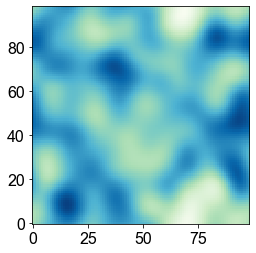

5940 50000 99 0.5277667080449298 -0.18126161783669686
24490.0 25000.0 24490.0 25000.0


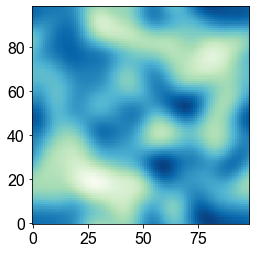

5940 50000 99 0.6853153359683124 -0.2546760231426821
24490.0 25000.0 24490.0 25000.0


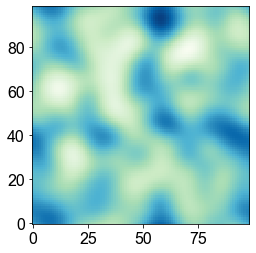

5940 50000 99 0.5214503369689704 -0.09293401714468509
24490.0 25000.0 24490.0 25000.0


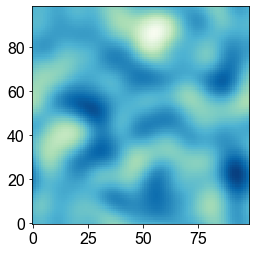

5940 50000 99 0.5276241685343201 0.07400953295930428
24490.0 25000.0 24490.0 25000.0


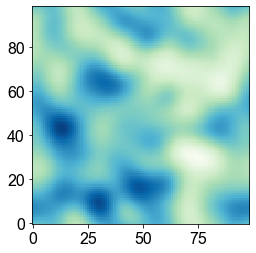

5940 50000 99 0.5537639033069675 -0.17927002860508537
24490.0 25000.0 24490.0 25000.0


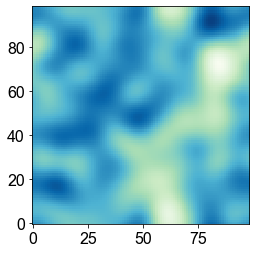

5940 50000 99 0.6123763139047413 0.11632067014574782
24490.0 25000.0 24490.0 25000.0


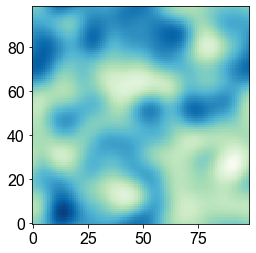

5940 50000 99 0.5497311010480886 -0.03489212648762581
24490.0 25000.0 24490.0 25000.0


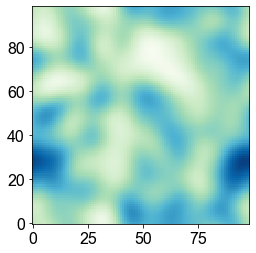

5940 50000 99 0.5274969846245802 -0.01737548680514043
24490.0 25000.0 24490.0 25000.0


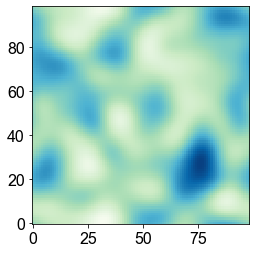

5940 50000 99 0.5466849955423367 -0.27171126987833455
24490.0 25000.0 24490.0 25000.0


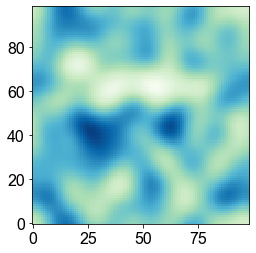

5940 50000 99 0.5144392669141632 -0.3253853423435597
24490.0 25000.0 24490.0 25000.0


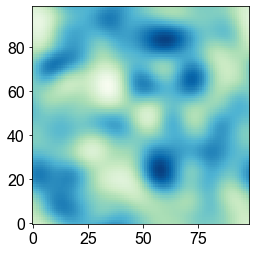

5940 50000 99 0.4939705419140456 0.09393740708755807
24490.0 25000.0 24490.0 25000.0


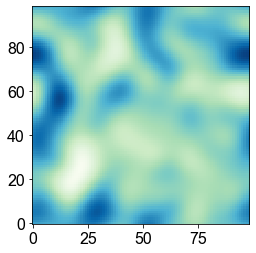

5940 50000 99 0.5651933331469572 0.184691318421687
24490.0 25000.0 24490.0 25000.0


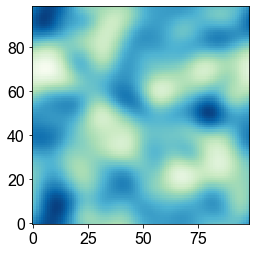

5940 50000 99 0.5717770173045199 -0.20641439960028132
24490.0 25000.0 24490.0 25000.0


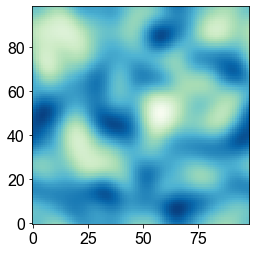

5940 50000 99 0.5370501288483084 0.0009642673317983931
24490.0 25000.0 24490.0 25000.0


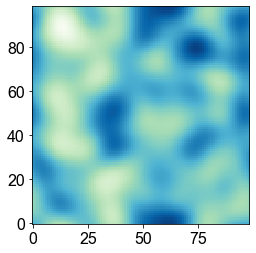

5940 50000 99 0.5388184073775307 0.12889821538833332
24490.0 25000.0 24490.0 25000.0


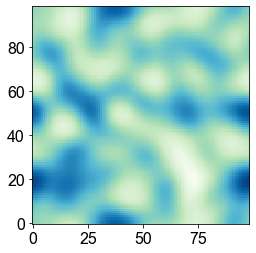

5940 50000 99 0.4621314536943022 0.1164281366465484
24490.0 25000.0 24490.0 25000.0


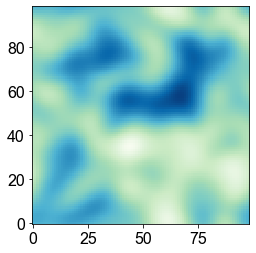

5940 50000 99 0.5950558231274519 -0.27263936561376956
24490.0 25000.0 24490.0 25000.0


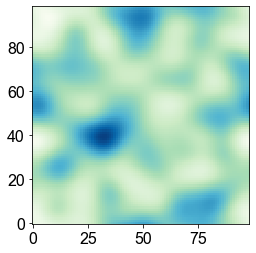

5940 50000 99 0.6546611170594656 -0.0333972815839547
24490.0 25000.0 24490.0 25000.0


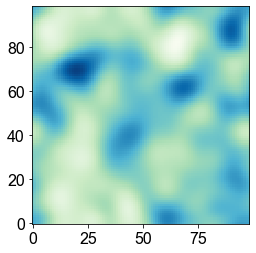

5940 50000 99 0.4744453024245869 -0.22069142987704032
24490.0 25000.0 24490.0 25000.0


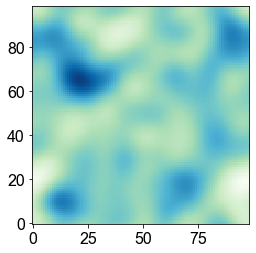

5940 50000 99 0.5712918254289547 -0.2655794048980626
24490.0 25000.0 24490.0 25000.0


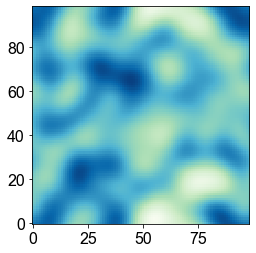

5940 50000 99 0.5340486447999698 0.04050300778320893
24490.0 25000.0 24490.0 25000.0


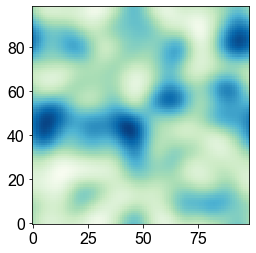

5940 50000 99 0.5552454314935779 -0.07611687737760667
24490.0 25000.0 24490.0 25000.0


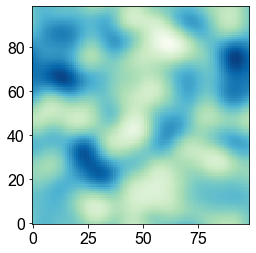

5940 50000 99 0.5911445996875963 -0.1668874885535768
24490.0 25000.0 24490.0 25000.0


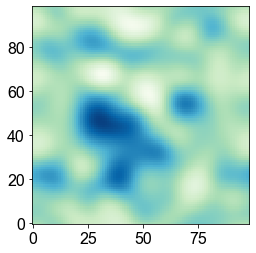

5940 50000 99 0.5059765414243952 -0.08091560764531454
24490.0 25000.0 24490.0 25000.0


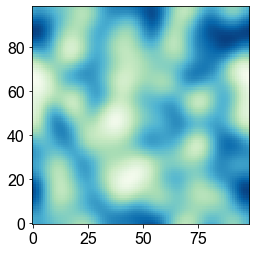

5940 50000 99 0.4512363575868499 -0.04094288720617299
24490.0 25000.0 24490.0 25000.0


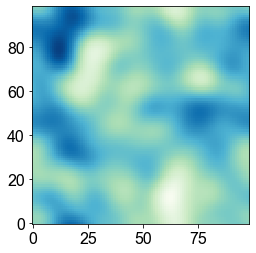

5940 50000 99 0.5883020330010448 0.01157369861284531
24490.0 25000.0 24490.0 25000.0


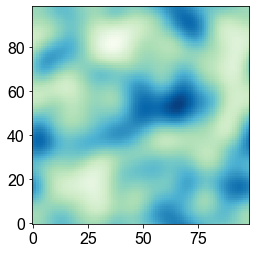

5940 50000 99 0.5947373782782367 -0.019159477952718416
24490.0 25000.0 24490.0 25000.0


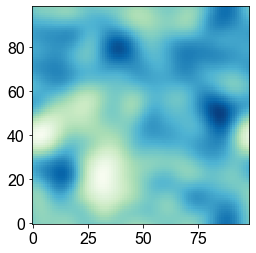

5940 50000 99 0.6094428521264649 -0.2138872547531373
24490.0 25000.0 24490.0 25000.0


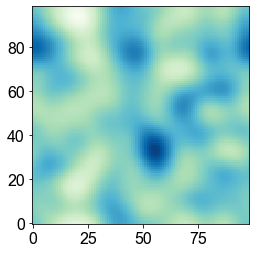

5940 50000 99 0.5517865178391751 0.01204260726351736
24490.0 25000.0 24490.0 25000.0


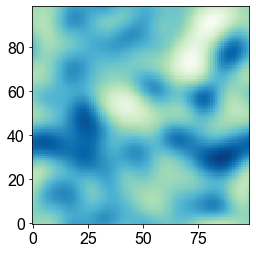

5940 50000 99 0.5988753761267956 0.16159179944902227
24490.0 25000.0 24490.0 25000.0


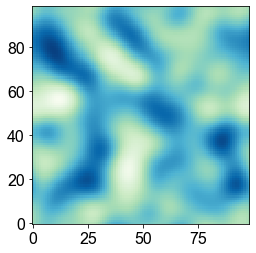

5940 50000 99 0.46399612832392734 -0.1250043462910175
24490.0 25000.0 24490.0 25000.0


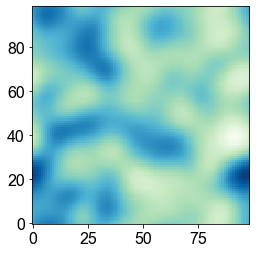

5940 50000 99 0.5971815147985486 0.05332188649484778
24490.0 25000.0 24490.0 25000.0


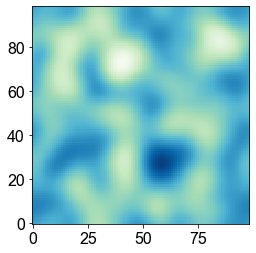

5940 50000 99 0.5518510589453182 0.06543038195525541
24490.0 25000.0 24490.0 25000.0


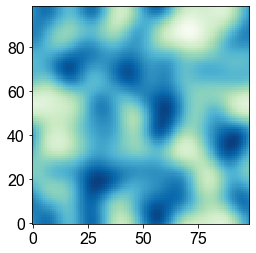

5940 50000 99 0.5831944194391222 -0.02801046621352677
24490.0 25000.0 24490.0 25000.0


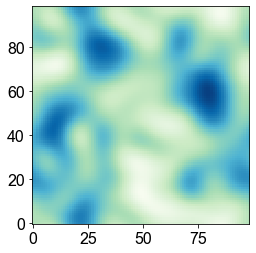

5940 50000 99 0.6339893552654067 -0.08769325297375406
24490.0 25000.0 24490.0 25000.0


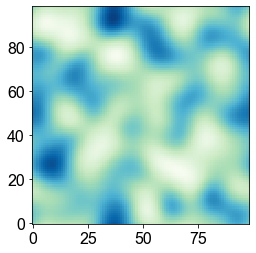

5940 50000 99 0.5029405158967002 0.056414241687962684
24490.0 25000.0 24490.0 25000.0


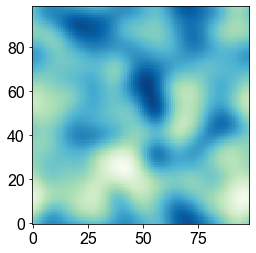

5940 50000 99 0.6619303797884066 -0.0559502414485154
24490.0 25000.0 24490.0 25000.0


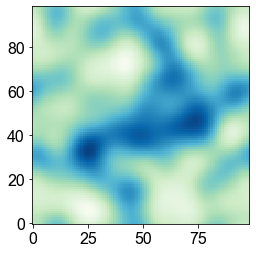

5940 50000 99 0.6852996392428616 0.11305861013914273
24490.0 25000.0 24490.0 25000.0


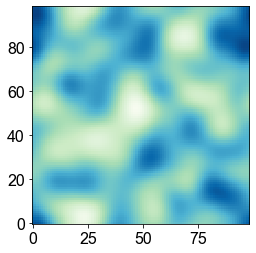

5940 50000 99 0.5242862836440085 0.06262431021715993
24490.0 25000.0 24490.0 25000.0


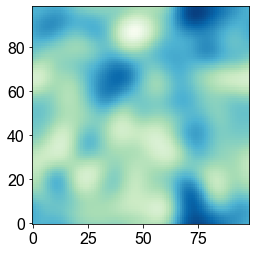

5940 50000 99 0.5849240795194212 0.04379969348065809
24490.0 25000.0 24490.0 25000.0


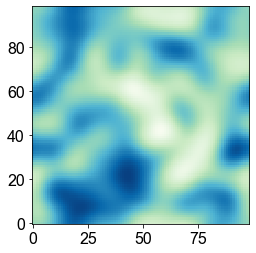

5940 50000 99 0.5351250698258982 -0.16646663538253698
24490.0 25000.0 24490.0 25000.0


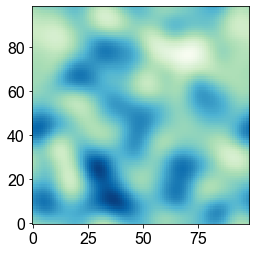

5940 50000 99 0.4724460274818028 -0.05371408566659485
24490.0 25000.0 24490.0 25000.0


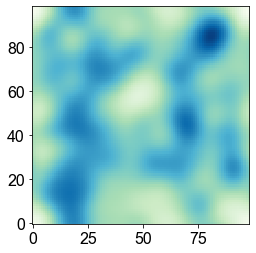

5940 50000 99 0.5892970077626463 0.17516644279138854
24490.0 25000.0 24490.0 25000.0


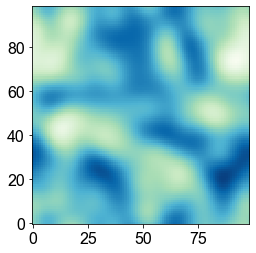

5940 50000 99 0.5538819097035624 0.08392936090455067
24490.0 25000.0 24490.0 25000.0


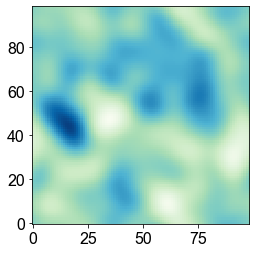

5940 50000 99 0.5767992632664113 0.20355087314694859
24490.0 25000.0 24490.0 25000.0


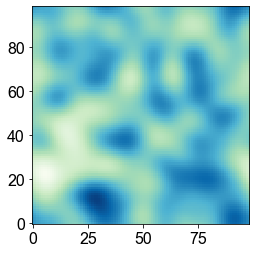

5940 50000 99 0.47188753800831335 -0.055040341858798546
24490.0 25000.0 24490.0 25000.0


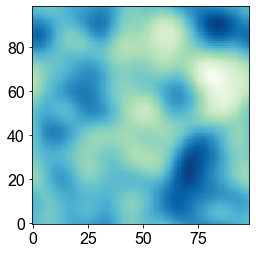

5940 50000 99 0.7230127519712902 -0.14396519490802442
24490.0 25000.0 24490.0 25000.0


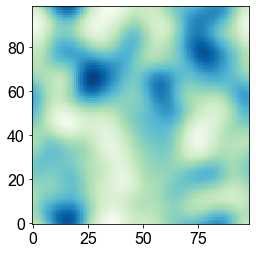

5940 50000 99 0.6596295996744577 -0.029491212511931177
24490.0 25000.0 24490.0 25000.0


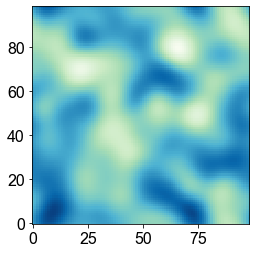

5940 50000 99 0.46153455150851624 -0.18298482425196985
24490.0 25000.0 24490.0 25000.0


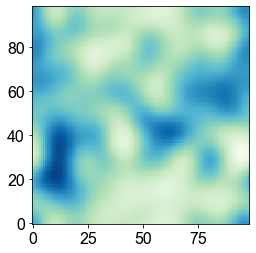

5940 50000 99 0.6759101755651116 0.06754255178821944
24490.0 25000.0 24490.0 25000.0


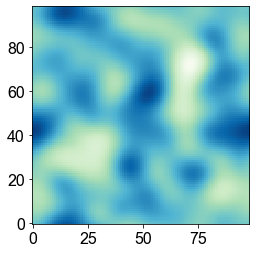

5940 50000 99 0.569066287270329 0.10360846080785306
24490.0 25000.0 24490.0 25000.0


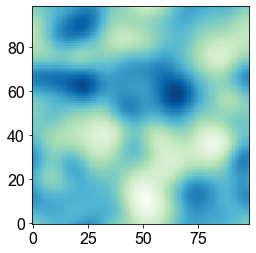

5940 50000 99 0.7133464798308676 -0.1512569648872707
24490.0 25000.0 24490.0 25000.0


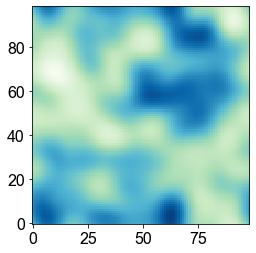

5940 50000 99 0.6170081218659683 0.1694770182729221
24490.0 25000.0 24490.0 25000.0


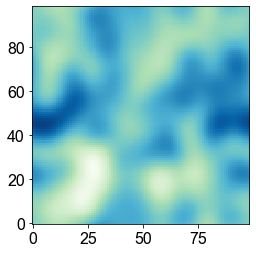

5940 50000 99 0.6141284608537347 -0.02539566426886066
24490.0 25000.0 24490.0 25000.0


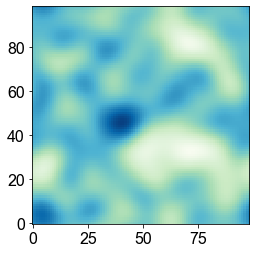

5940 50000 99 0.5870890516939447 -0.1043254166684199
24490.0 25000.0 24490.0 25000.0


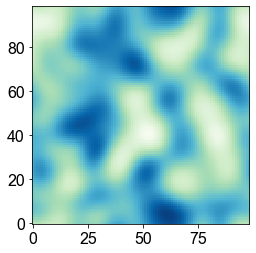

5940 50000 99 0.5416305975214735 0.048545408297344154
24490.0 25000.0 24490.0 25000.0


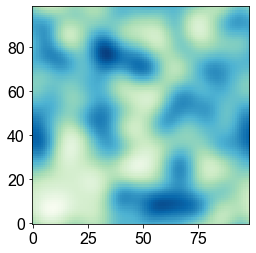

5940 50000 99 0.5300515005570158 -0.19231802006346488
24490.0 25000.0 24490.0 25000.0


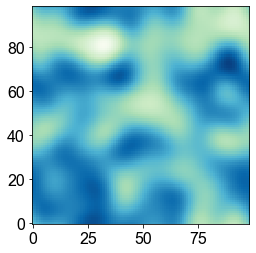

5940 50000 99 0.6385781848737566 -0.20047152065843557
24490.0 25000.0 24490.0 25000.0


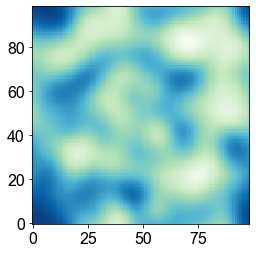

5940 50000 99 0.6534204243444045 -0.2046790382315072
24490.0 25000.0 24490.0 25000.0


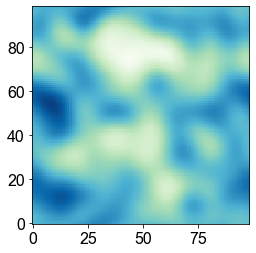

5940 50000 99 0.5697240976415451 0.057929807238314444
24490.0 25000.0 24490.0 25000.0


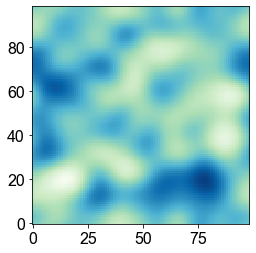

5940 50000 99 0.5334633074319879 -0.07622703912544031
24490.0 25000.0 24490.0 25000.0


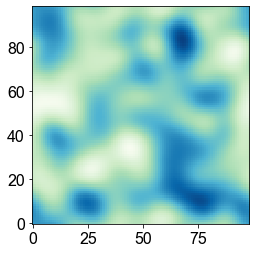

5940 50000 99 0.5394777865230295 0.07877984513266109
24490.0 25000.0 24490.0 25000.0


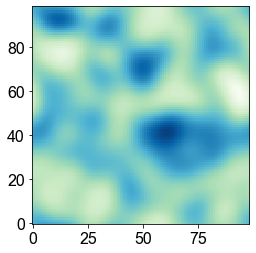

5940 50000 99 0.5418937639107857 0.09107832671433684
24490.0 25000.0 24490.0 25000.0


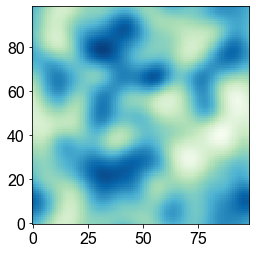

5940 50000 99 0.5457468421388685 -0.1245685929360958
24490.0 25000.0 24490.0 25000.0


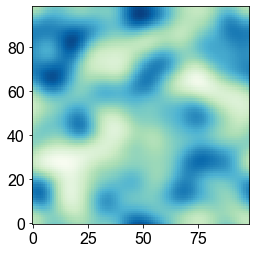

5940 50000 99 0.5341269777422398 0.10498455543523615
24490.0 25000.0 24490.0 25000.0


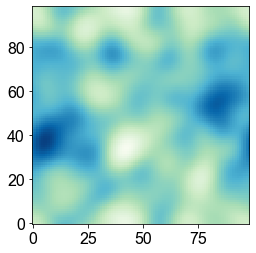

5940 50000 99 0.5565029011361771 0.18507337871914178
24490.0 25000.0 24490.0 25000.0


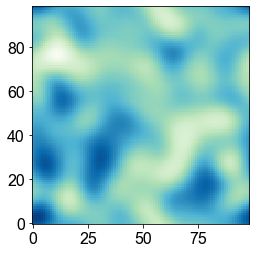

5940 50000 99 0.44858957384337683 -0.27435326029911555
24490.0 25000.0 24490.0 25000.0


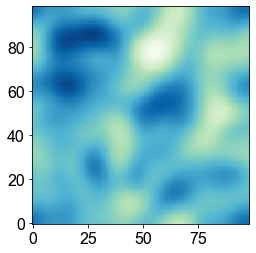

5940 50000 99 0.6628920181899054 -0.07807982710839814
24490.0 25000.0 24490.0 25000.0


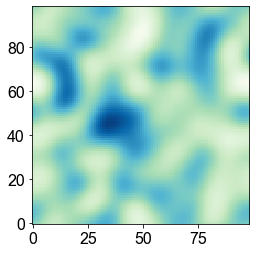

5940 50000 99 0.4654978703462114 -0.00413047886072142
24490.0 25000.0 24490.0 25000.0


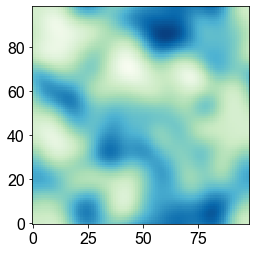

5940 50000 99 0.7316644634399653 0.02783870671311017
24490.0 25000.0 24490.0 25000.0


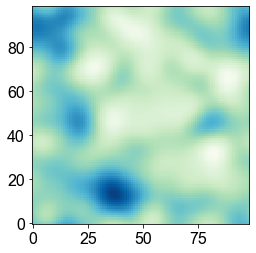

5940 50000 99 0.6064274845342973 -0.022346464568306457
24490.0 25000.0 24490.0 25000.0


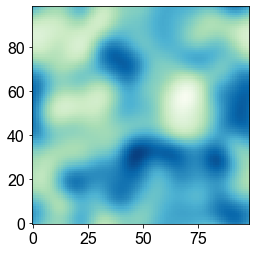

5940 50000 99 0.6750364619098616 0.16566241992775319
24490.0 25000.0 24490.0 25000.0


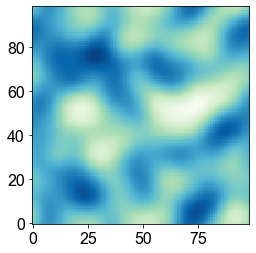

5940 50000 99 0.5844605598666317 0.29751898683435735
24490.0 25000.0 24490.0 25000.0


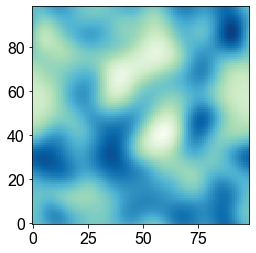

5940 50000 99 0.6800838423801876 -0.03464601362909378
24490.0 25000.0 24490.0 25000.0


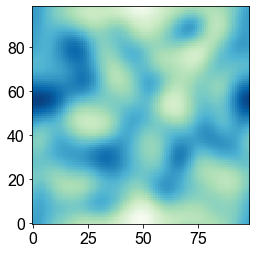

5940 50000 99 0.5736595927094513 -0.04827941184769916
24490.0 25000.0 24490.0 25000.0


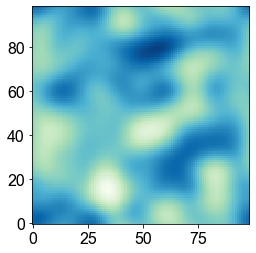

5940 50000 99 0.5421042408304537 -0.013810384330581415
24490.0 25000.0 24490.0 25000.0


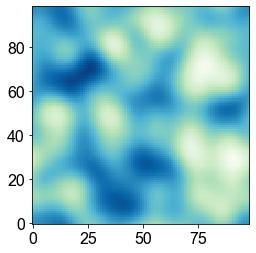

5940 50000 99 0.617069480141338 0.018651292603384835
24490.0 25000.0 24490.0 25000.0


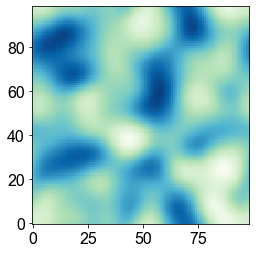

5940 50000 99 0.6528620458352985 0.05475361795074053
24490.0 25000.0 24490.0 25000.0


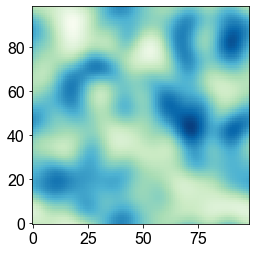

5940 50000 99 0.5108618384834895 0.037776017471696705
24490.0 25000.0 24490.0 25000.0


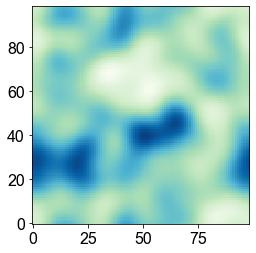

5940 50000 99 0.6303348514451852 0.0013415514937993196
24490.0 25000.0 24490.0 25000.0


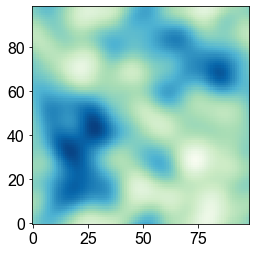

5940 50000 99 0.6663194037704327 0.0894346220477294
24490.0 25000.0 24490.0 25000.0


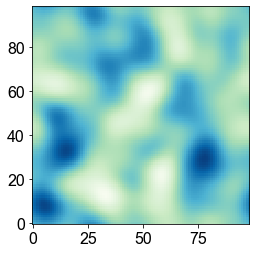

5940 50000 99 0.4817150557266275 -0.06880733270525308
24490.0 25000.0 24490.0 25000.0


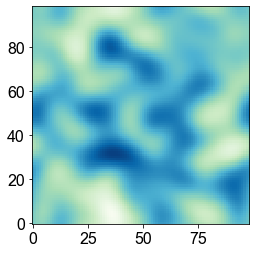

5940 50000 99 0.4605381039827339 -0.03619666861637082
24490.0 25000.0 24490.0 25000.0


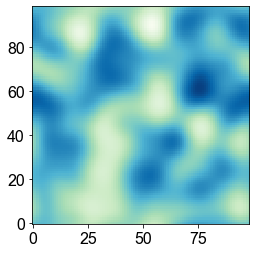

5940 50000 99 0.5216195660957764 0.04351557034776488
24490.0 25000.0 24490.0 25000.0


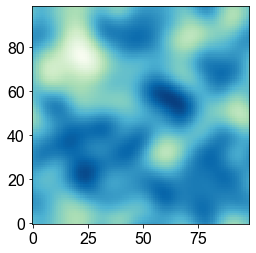

5940 50000 99 0.6177259676599124 -0.11676903610186218
24490.0 25000.0 24490.0 25000.0


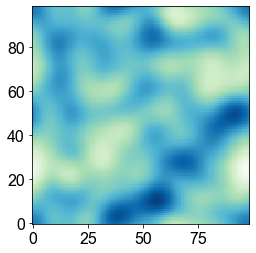

5940 50000 99 0.4926221307657968 0.04153587130201795
24490.0 25000.0 24490.0 25000.0


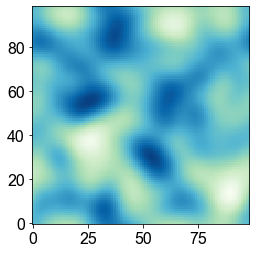

5940 50000 99 0.5664381574169405 0.21542610891302763
24490.0 25000.0 24490.0 25000.0


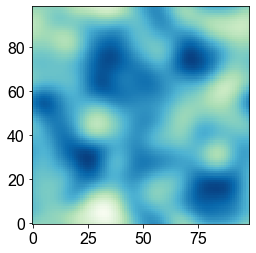

5940 50000 99 0.6133401318715827 0.2946553955440277
24490.0 25000.0 24490.0 25000.0


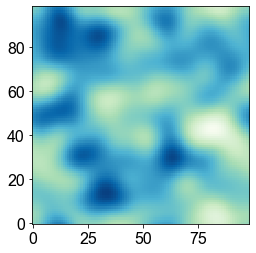

5940 50000 99 0.558002253421334 0.12560856083649075
24490.0 25000.0 24490.0 25000.0


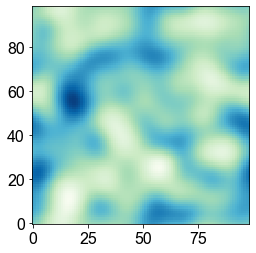

5940 50000 99 0.45315114287292396 0.11102297059613989
24490.0 25000.0 24490.0 25000.0


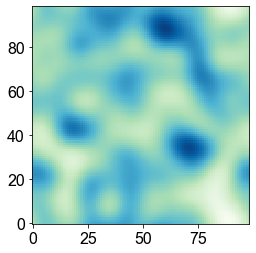

5940 50000 99 0.5008182866871157 -0.07364555092789318
24490.0 25000.0 24490.0 25000.0


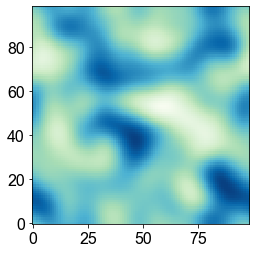

5940 50000 99 0.6212579599992303 -0.15505614612013863
24490.0 25000.0 24490.0 25000.0


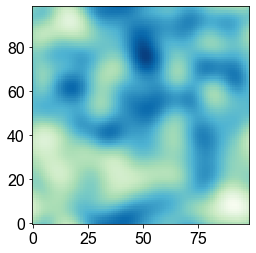

5940 50000 99 0.5240164696520119 0.03778542197831756
24490.0 25000.0 24490.0 25000.0


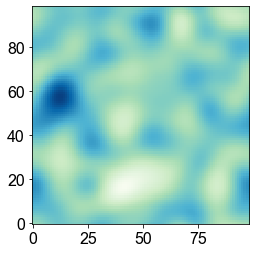

5940 50000 99 0.4913283288044478 -0.08600015924378225
24490.0 25000.0 24490.0 25000.0


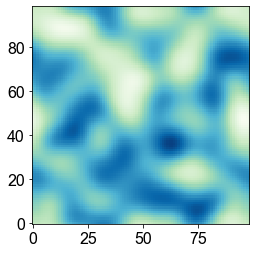

5940 50000 99 0.585740713296205 0.11102380216952626
24490.0 25000.0 24490.0 25000.0


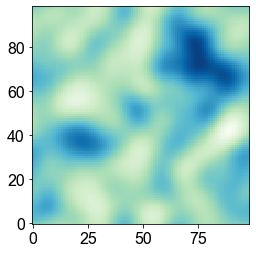

5940 50000 99 0.5170534788452881 0.2177362967497001
24490.0 25000.0 24490.0 25000.0


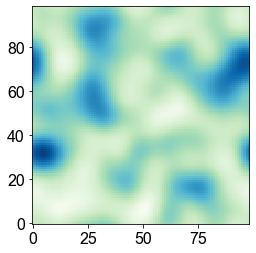

5940 50000 99 0.5669158308420806 0.05393877627367573
24490.0 25000.0 24490.0 25000.0


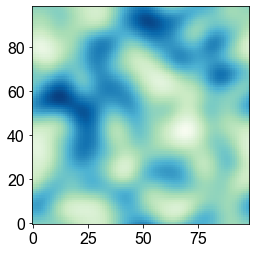

5940 50000 99 0.4707517033072265 0.12839924065993996
24490.0 25000.0 24490.0 25000.0


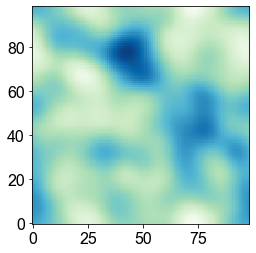

5940 50000 99 0.6557270639967385 -0.07818800227162495
24490.0 25000.0 24490.0 25000.0


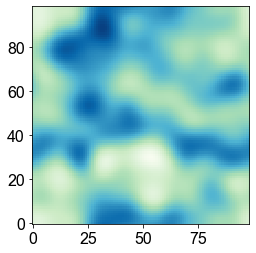

5940 50000 99 0.4955890334368255 -0.04640640249478801
24490.0 25000.0 24490.0 25000.0


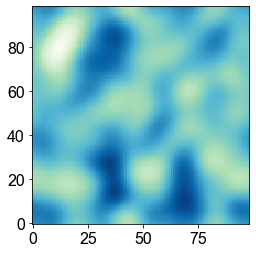

5940 50000 99 0.47372402349737275 -0.23643795610153331
24490.0 25000.0 24490.0 25000.0


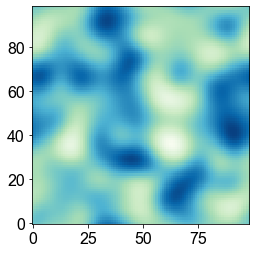

5940 50000 99 0.5069476695146766 -0.10173810935470201
24490.0 25000.0 24490.0 25000.0


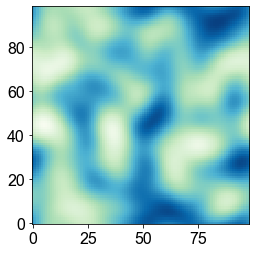

5940 50000 99 0.47245366946375156 -0.05374254138363708
24490.0 25000.0 24490.0 25000.0


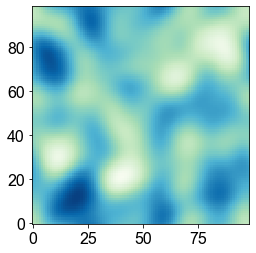

5940 50000 99 0.5700837798543036 0.08264271400944745
24490.0 25000.0 24490.0 25000.0


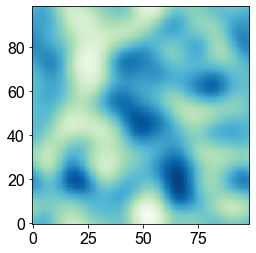

5940 50000 99 0.548964410904207 -0.04306384426432991
24490.0 25000.0 24490.0 25000.0


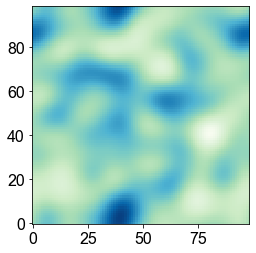

5940 50000 99 0.5824251135202432 0.051893526248315135
24490.0 25000.0 24490.0 25000.0


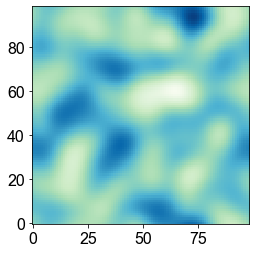

5940 50000 99 0.5520395820739098 -0.04637151293498084
24490.0 25000.0 24490.0 25000.0


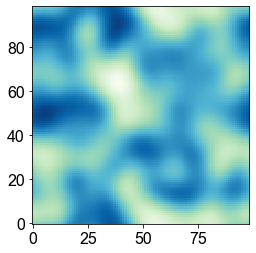

5940 50000 99 0.558435793686184 -0.23293781438713282
24490.0 25000.0 24490.0 25000.0


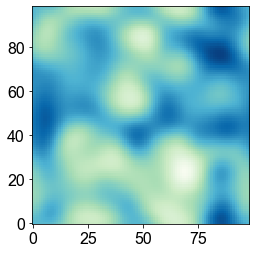

5940 50000 99 0.5890829882028257 -0.04525233714761965
24490.0 25000.0 24490.0 25000.0


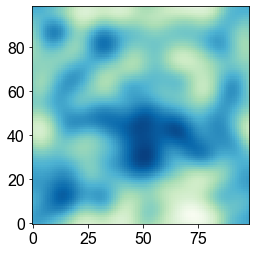

5940 50000 99 0.607712849043937 -0.10071080640484266
24490.0 25000.0 24490.0 25000.0


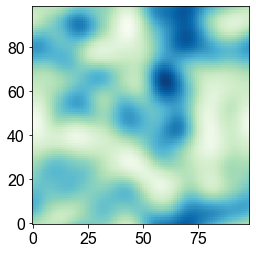

5940 50000 99 0.6220847907120661 -0.20229931906023285
24490.0 25000.0 24490.0 25000.0


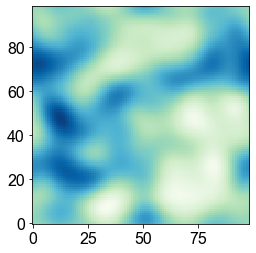

5940 50000 99 0.6501854504506264 -0.12878330997325965
24490.0 25000.0 24490.0 25000.0


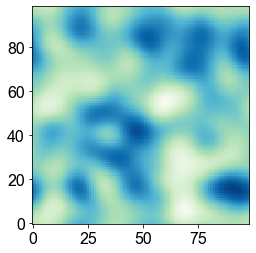

5940 50000 99 0.4695729985668331 0.0532064502090919
24490.0 25000.0 24490.0 25000.0


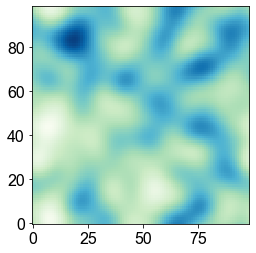

5940 50000 99 0.43759564812811125 0.06485826573909971
24490.0 25000.0 24490.0 25000.0


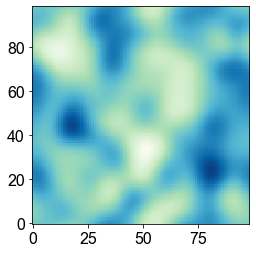

5940 50000 99 0.5476441737455123 -0.24477581590450206
24490.0 25000.0 24490.0 25000.0


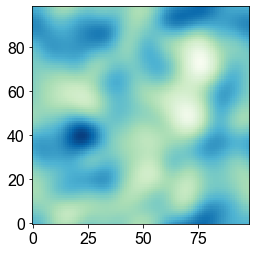

5940 50000 99 0.6581399137953954 -0.11882451965530251
24490.0 25000.0 24490.0 25000.0


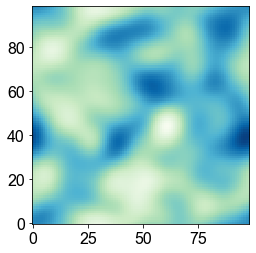

5940 50000 99 0.4564483243986513 0.1304962555755469
24490.0 25000.0 24490.0 25000.0


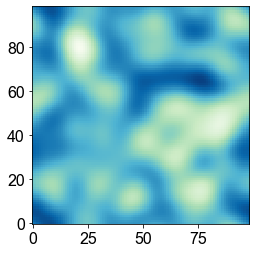

5940 50000 99 0.45737006084473963 -0.08415894978849107
24490.0 25000.0 24490.0 25000.0


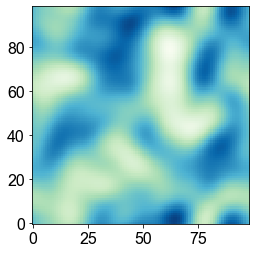

5940 50000 99 0.5765075036278172 0.02156210141883646
24490.0 25000.0 24490.0 25000.0


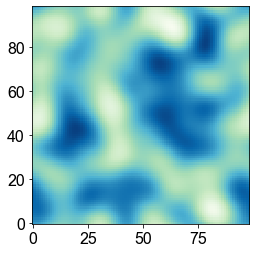

5940 50000 99 0.5612510496088078 0.03078438074691932
24490.0 25000.0 24490.0 25000.0


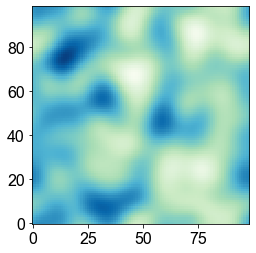

5940 50000 99 0.5014908378140182 0.10114528090414956
24490.0 25000.0 24490.0 25000.0


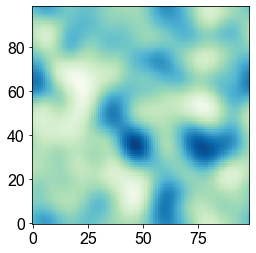

5940 50000 99 0.5047786600021779 -0.05092908240752105
24490.0 25000.0 24490.0 25000.0


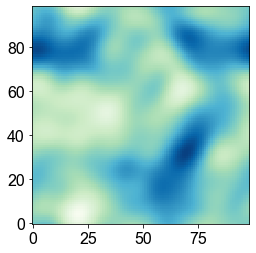

5940 50000 99 0.6614063281500583 0.05985272657689234
24490.0 25000.0 24490.0 25000.0


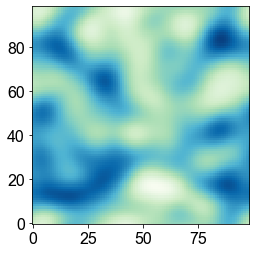

5940 50000 99 0.5377960875762436 0.0664855535880542
24490.0 25000.0 24490.0 25000.0


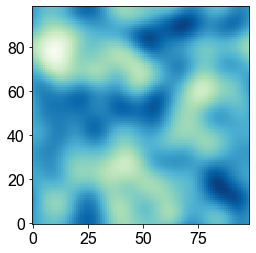

5940 50000 99 0.5827676977279047 -0.21963135357362296
24490.0 25000.0 24490.0 25000.0


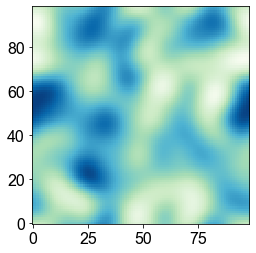

5940 50000 99 0.5642842006096408 -0.07932564935447099
24490.0 25000.0 24490.0 25000.0


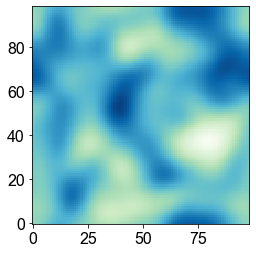

5940 50000 99 0.6612654404430313 -0.016789360207418995
24490.0 25000.0 24490.0 25000.0


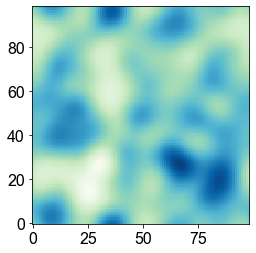

5940 50000 99 0.5181645813211953 -0.006349735988603388
24490.0 25000.0 24490.0 25000.0


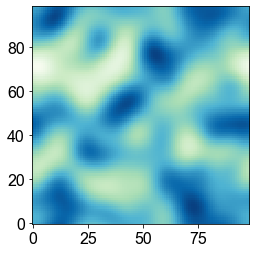

5940 50000 99 0.6219307909902362 0.0321549706227376
24490.0 25000.0 24490.0 25000.0


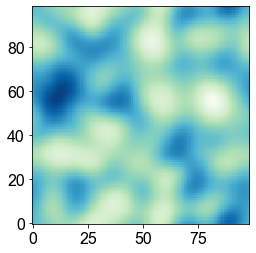

5940 50000 99 0.46866843758774396 -0.001944002427039245
24490.0 25000.0 24490.0 25000.0


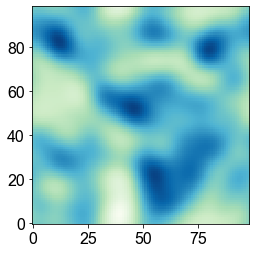

5940 50000 99 0.608900064370478 -0.08089414087749694
24490.0 25000.0 24490.0 25000.0


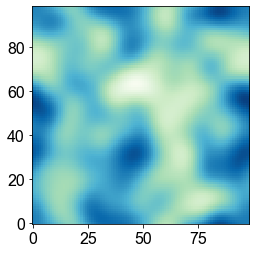

5940 50000 99 0.5521067094734547 -0.1543021091510503
24490.0 25000.0 24490.0 25000.0


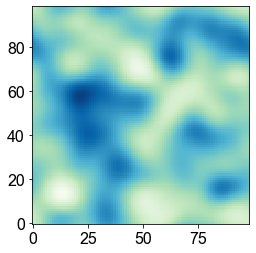

5940 50000 99 0.5284707193217609 -0.14382308796336532
24490.0 25000.0 24490.0 25000.0


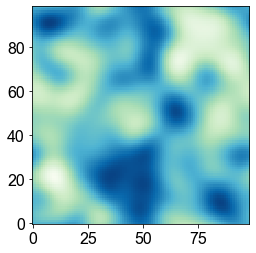

5940 50000 99 0.6001719105830148 0.10998437326893243
24490.0 25000.0 24490.0 25000.0


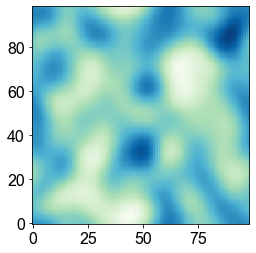

5940 50000 99 0.49043394913039745 -0.1066500616796248
24490.0 25000.0 24490.0 25000.0


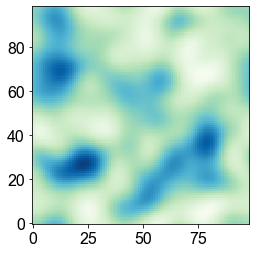

5940 50000 99 0.5401986014974487 0.15228096886309384
24490.0 25000.0 24490.0 25000.0


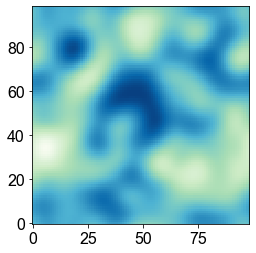

5940 50000 99 0.5465809977865969 -0.03522578797213572
24490.0 25000.0 24490.0 25000.0


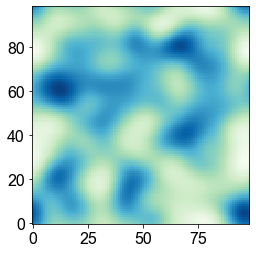

5940 50000 99 0.5140277341614496 0.0490200170116506
24490.0 25000.0 24490.0 25000.0


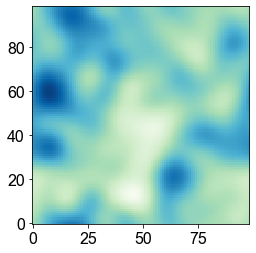

5940 50000 99 0.6035559677450574 -0.1352736068440441
24490.0 25000.0 24490.0 25000.0


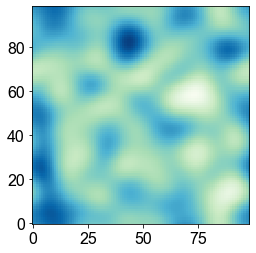

5940 50000 99 0.4825970373931818 0.15192707414124404
24490.0 25000.0 24490.0 25000.0


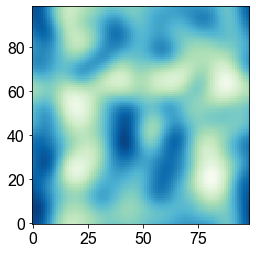

5940 50000 99 0.5712655148606444 0.007798621909379852
24490.0 25000.0 24490.0 25000.0


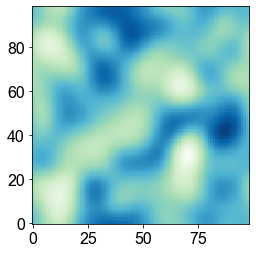

5940 50000 99 0.6020414415908767 0.013175868257685231
24490.0 25000.0 24490.0 25000.0


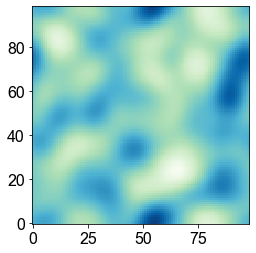

5940 50000 99 0.5326981517188395 -0.2198439546993814
24490.0 25000.0 24490.0 25000.0


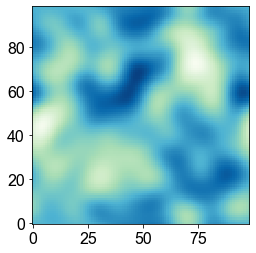

5940 50000 99 0.5314409379040401 0.23371761991989898
24490.0 25000.0 24490.0 25000.0


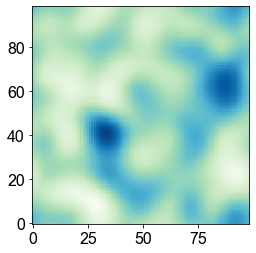

5940 50000 99 0.608388238292078 -0.18205854944253166
24490.0 25000.0 24490.0 25000.0


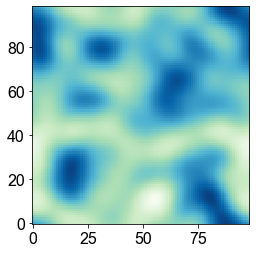

5940 50000 99 0.5231912753705705 0.1434722964763796
24490.0 25000.0 24490.0 25000.0


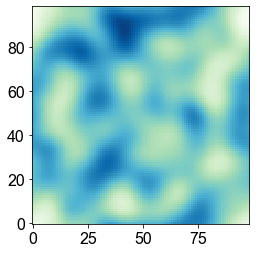

5940 50000 99 0.5020208611185263 0.16076966192817738
24490.0 25000.0 24490.0 25000.0


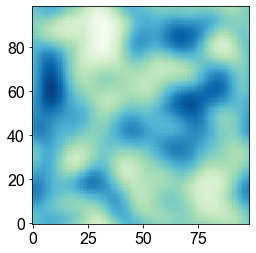

5940 50000 99 0.5983363418550223 0.04925746788159857
24490.0 25000.0 24490.0 25000.0


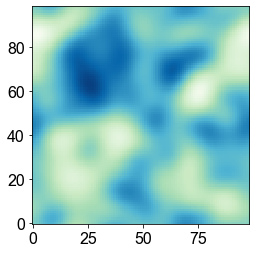

5940 50000 99 0.6011470503626086 -0.006793123201696319
24490.0 25000.0 24490.0 25000.0


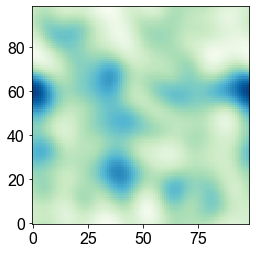

5940 50000 99 0.6133811152545636 0.06815137764640863
24490.0 25000.0 24490.0 25000.0


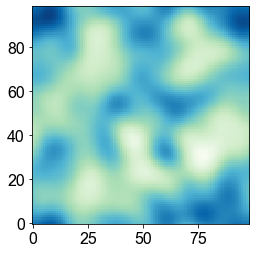

5940 50000 99 0.5503408404059377 0.10871432290843487
24490.0 25000.0 24490.0 25000.0


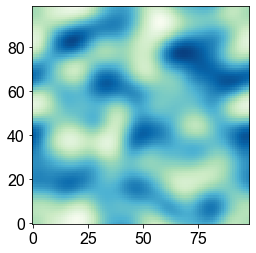

5940 50000 99 0.5046023370927393 0.19948755799092266
24490.0 25000.0 24490.0 25000.0


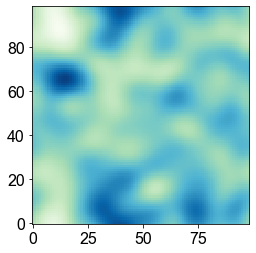

5940 50000 99 0.5532830329800515 -0.0029951642569640206
24490.0 25000.0 24490.0 25000.0


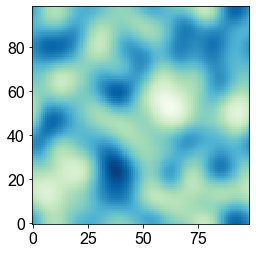

5940 50000 99 0.5455994925489396 -0.025950432742289812
24490.0 25000.0 24490.0 25000.0


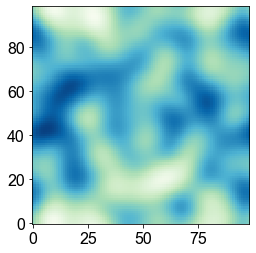

5940 50000 99 0.5997709563464665 -0.11888908647533449
24490.0 25000.0 24490.0 25000.0


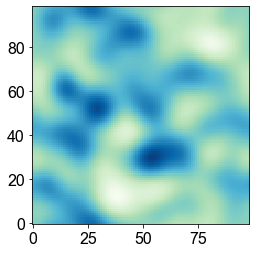

5940 50000 99 0.5629321875074934 -0.029515906735905928
24490.0 25000.0 24490.0 25000.0


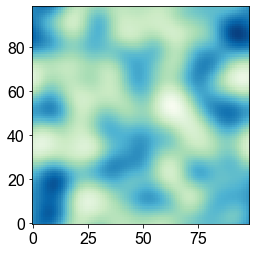

5940 50000 99 0.5926129579940074 -0.08826306962725398
24490.0 25000.0 24490.0 25000.0


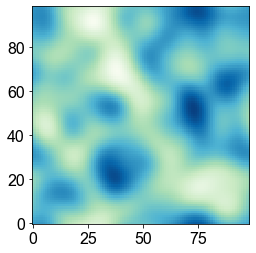

5940 50000 99 0.5825464832055178 0.02626502927396059
24490.0 25000.0 24490.0 25000.0


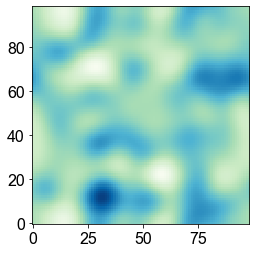

5940 50000 99 0.49469415353501933 0.07648294264992576
24490.0 25000.0 24490.0 25000.0


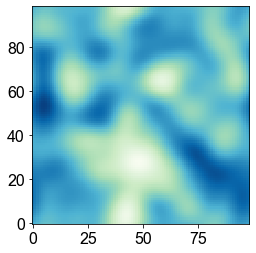

5940 50000 99 0.6403555732293927 0.06774258612468308
24490.0 25000.0 24490.0 25000.0


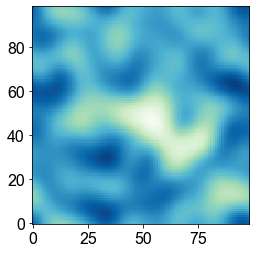

5940 50000 99 0.5545301717944108 0.17709169024473895
24490.0 25000.0 24490.0 25000.0


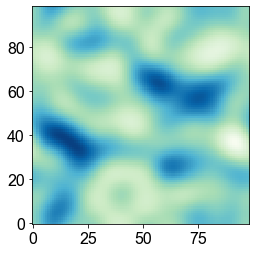

5940 50000 99 0.5502722003726209 -0.05613475418752055
24490.0 25000.0 24490.0 25000.0


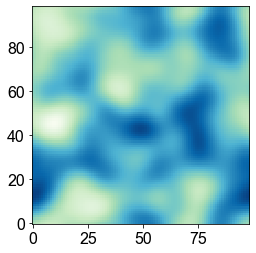

5940 50000 99 0.5322290982518554 0.15031352400186662
24490.0 25000.0 24490.0 25000.0


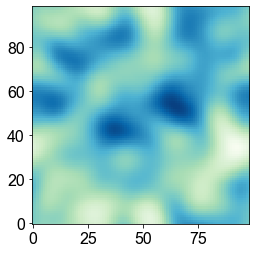

5940 50000 99 0.5730908000523378 0.11123844115538271
24490.0 25000.0 24490.0 25000.0


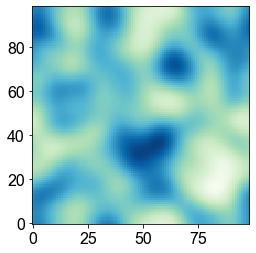

5940 50000 99 0.6124512329400544 0.15875028159240506
24490.0 25000.0 24490.0 25000.0


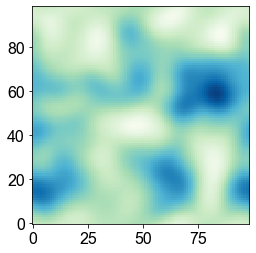

5940 50000 99 0.6029122535420479 0.019207757415597073
24490.0 25000.0 24490.0 25000.0


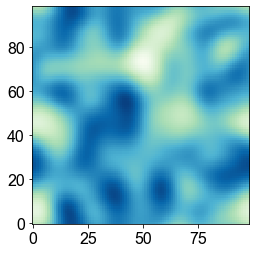

5940 50000 99 0.516091302547949 0.09746932486235033
24490.0 25000.0 24490.0 25000.0


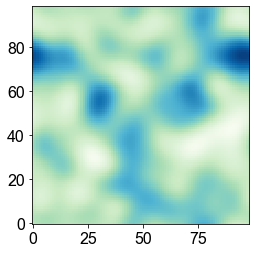

5940 50000 99 0.4867862226154521 -0.018619504733681562
24490.0 25000.0 24490.0 25000.0


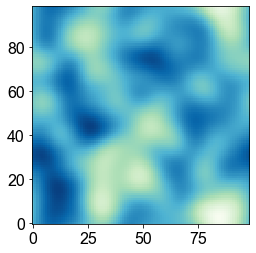

5940 50000 99 0.5979027923271539 -0.06488490816986929
24490.0 25000.0 24490.0 25000.0


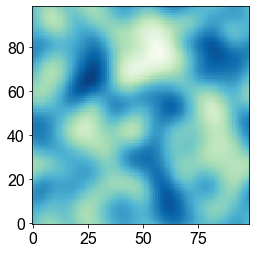

5940 50000 99 0.5015411558883197 0.30946386069944176
24490.0 25000.0 24490.0 25000.0


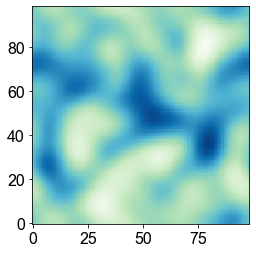

5940 50000 99 0.5731351610055805 0.04776289836801724
24490.0 25000.0 24490.0 25000.0


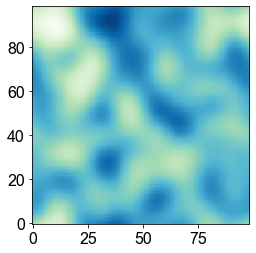

5940 50000 99 0.6178117000335995 -0.139486453487234
24490.0 25000.0 24490.0 25000.0


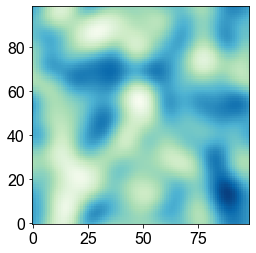

5940 50000 99 0.5037068120208094 -0.06981206751286523
24490.0 25000.0 24490.0 25000.0


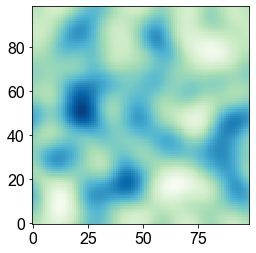

5940 50000 99 0.5328680618409718 -0.22445978526059976
24490.0 25000.0 24490.0 25000.0


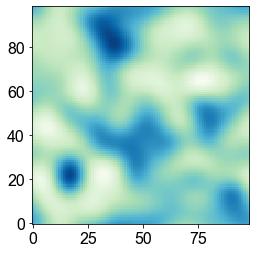

5940 50000 99 0.5462218778369875 -0.10550295713239374
24490.0 25000.0 24490.0 25000.0


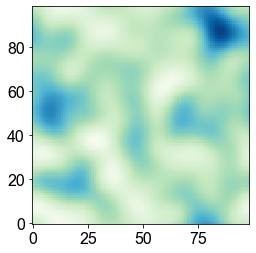

5940 50000 99 0.5325782243042407 0.12741973845362126
24490.0 25000.0 24490.0 25000.0


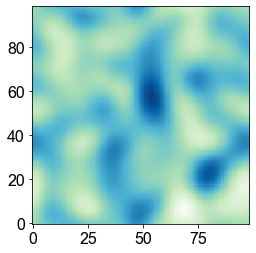

5940 50000 99 0.4592686824407848 0.0640738509729011
24490.0 25000.0 24490.0 25000.0


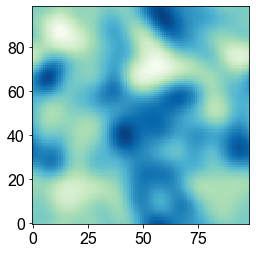

5940 50000 99 0.51437027853859 0.08008789897453408
24490.0 25000.0 24490.0 25000.0


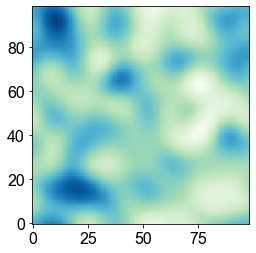

5940 50000 99 0.5516919792216094 -0.06696857080483956
24490.0 25000.0 24490.0 25000.0


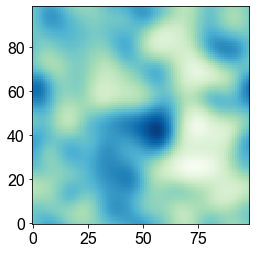

5940 50000 99 0.594653234061275 0.10945653514691406
24490.0 25000.0 24490.0 25000.0


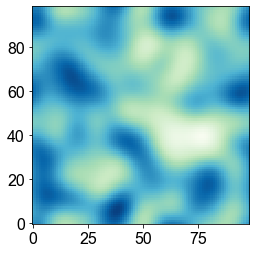

5940 50000 99 0.5945881318865126 -0.07093966594718845
24490.0 25000.0 24490.0 25000.0


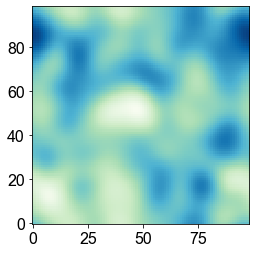

5940 50000 99 0.5874821093886436 0.18883699328237233
24490.0 25000.0 24490.0 25000.0


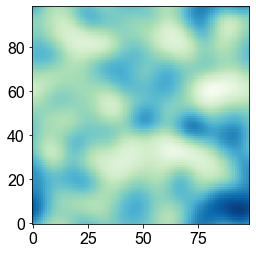

5940 50000 99 0.5678181185667984 0.0030025594888532844
24490.0 25000.0 24490.0 25000.0


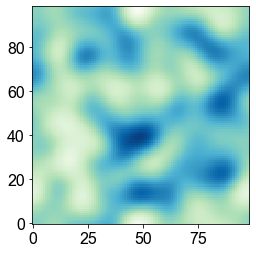

5940 50000 99 0.4907439259773766 0.0771552470969687
24490.0 25000.0 24490.0 25000.0


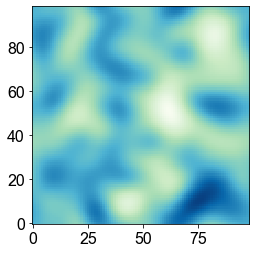

5940 50000 99 0.5488944836930816 0.23549691002822598
24490.0 25000.0 24490.0 25000.0


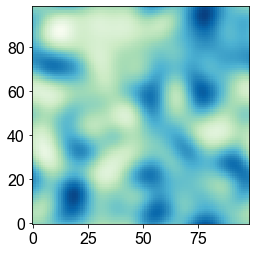

5940 50000 99 0.4556023965016418 -0.028969952622304396
24490.0 25000.0 24490.0 25000.0


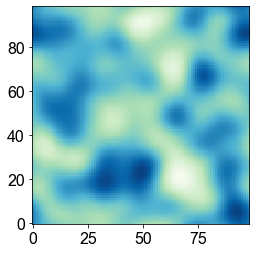

5940 50000 99 0.464687878364164 0.18181789984209687
24490.0 25000.0 24490.0 25000.0


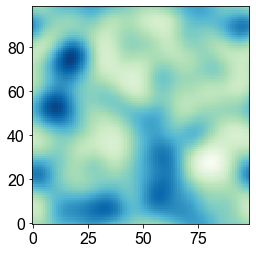

5940 50000 99 0.6561949515607176 0.13366327097552796
24490.0 25000.0 24490.0 25000.0


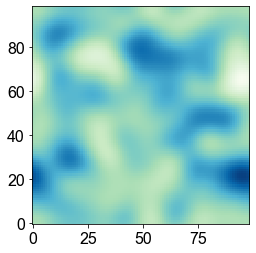

5940 50000 99 0.6233999861976055 -0.27228393570989046
24490.0 25000.0 24490.0 25000.0


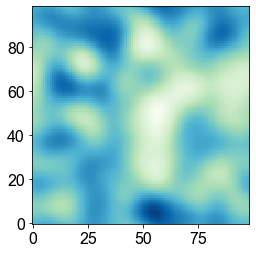

5940 50000 99 0.553812622280185 -0.061780128126076486
24490.0 25000.0 24490.0 25000.0


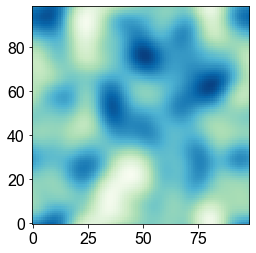

5940 50000 99 0.662947226147327 0.20255671234782532
24490.0 25000.0 24490.0 25000.0


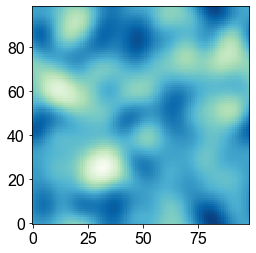

5940 50000 99 0.5383653223524334 0.07878085209768126
24490.0 25000.0 24490.0 25000.0


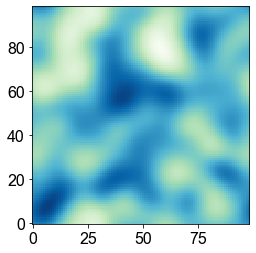

5940 50000 99 0.6264781889460181 0.1443814239627394
24490.0 25000.0 24490.0 25000.0


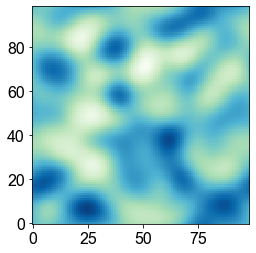

5940 50000 99 0.4489099991577126 0.14614057923823384
24490.0 25000.0 24490.0 25000.0


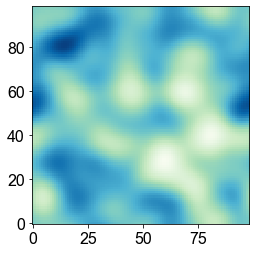

5940 50000 99 0.6465308367691318 -0.030467159486113938
24490.0 25000.0 24490.0 25000.0


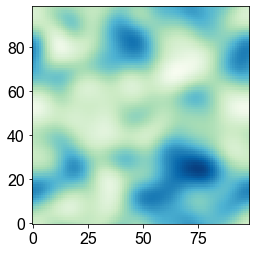

5940 50000 99 0.5890855562134784 0.1222179117530358
24490.0 25000.0 24490.0 25000.0


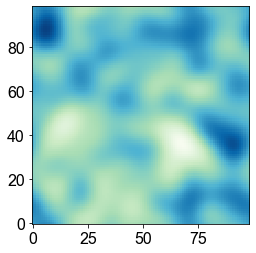

5940 50000 99 0.5648339645911079 -0.02208118976357381
24490.0 25000.0 24490.0 25000.0


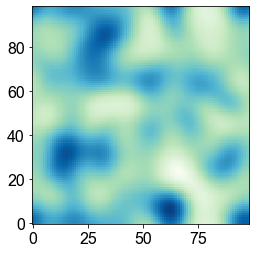

5940 50000 99 0.5864235977824545 -0.006693525121941222


In [177]:
h = 0.585 #nm 
cl = 5940 #microns


# cl*3 is what we are interested in so make our multiplier a multiple of 3
cl_ml =3

multiplier = int(cl_ml*round(9/cl_ml))

rL =  50000#int(multiplier * cl)

#510
N = int(rL/510)+1#2*int( np.ceil(rL/(multiplier/2))) #number of points

plot = 'y'

wafer_x_val = [] # x coordinates from wafer measurements
wafer_y_val = [] # y coordinates from wafer measurements
[wafer_x_val.append(each) for each in tot_hx_array if each not in wafer_x_val]
[wafer_y_val.append(each) for each in tot_hy_array if each not in wafer_y_val]
wafer_x_val = np.sort(wafer_x_val, axis=None, kind='mergesort')
wafer_y_val = np.sort(wafer_y_val, axis=None, kind='mergesort')

while True:
    waferx, wafery, waferf = surfgen2D(N, rL, h, cl, wafer_x_val, wafer_y_val, plot)
    print(cl, rL, N, np.std(waferf), np.mean(waferf))
    if(np.std(waferf)>h-0.005 and np.std(waferf)<h+0.005 and np.mean(waferf)>-0.01 and np.mean(waferf)<0.01):
        break



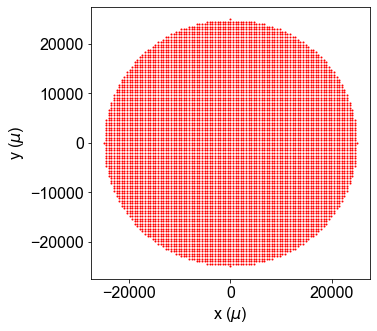

7525 7525


(0.0023484525925647217, 0.5894772998419554)

In [226]:
##################################
#Virtual Wafer

origin = [0, 0]
radius = 25000
tot_hx_array = []
tot_hy_array = []
tot_dh = []
for i in range(len(waferx)):
    for j in range(len(wafery)):
        temp_x = waferx[i,j]
        temp_y = wafery[i,j]
        if(np.sqrt(temp_x**2 + temp_y**2) <= radius):
                tot_hx_array.append(temp_x)
                tot_hy_array.append(temp_y)
                tot_dh.append(waferf[i,j])

fig = plt.figure()
plt.plot(tot_hx_array, tot_hy_array, 'ro', markersize = 1)
#plt.plot(tot_hx_arr, tot_hy_arr, 'bx', markersize = 1)
fig.set_size_inches(5,5)
plt.xlabel(r'x ($\mu$)')
plt.ylabel(r'y ($\mu$)')
plt.show()

print(len(tot_dh), len(tot_dh))
#np.save('raw_wafer_data',[tot_hx_array, tot_hy_array, tot_dh])

np.mean(tot_dh), np.std(tot_dh)

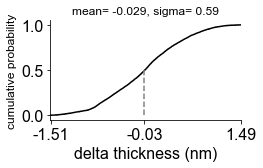

In [161]:
temp_data = tot_dh
fig = plt.figure()
h, edges = np.histogram(temp_data, density=False, bins=len(temp_data))
h = np.cumsum(h)/np.cumsum(h).max()
X = edges.repeat(2)[:-1]
y = np.zeros_like(X)
y[1:] = h.repeat(2)
plt.plot(X, y, 'k')
plt.plot([round(np.mean(temp_data),2), round(np.mean(temp_data),2)],[0, 0.5], linestyle='--', color= 'grey')
plt.xlim(left =min(temp_data), right= max(temp_data))
plt.xticks([round(min(temp_data),2), np.mean(temp_data), round(max(temp_data),2)], [round(min(temp_data),2), round(np.mean(temp_data),2), round(max(temp_data),2)])
plt.yticks([0, 0.5, 1])
plt.xlabel('delta thickness (nm)')
plt.ylabel('cumulative probability', fontsize=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

#plt.title('mean = '+str(np.mean(temp_data))[0:5]+' (nm), sigma = '+ str(np.std(temp_data))[0:5]+' (nm)', fontsize = 18)
fig.set_size_inches(1.5*2.625, 2.625)
plt.title('mean= ' +str(np.mean(temp_data))[:6]+', sigma= ' + str(np.std(temp_data))[:4], fontsize=12)
plt.tight_layout()
#plt.savefig('die_mean_sigma.pdf', dpi=600)

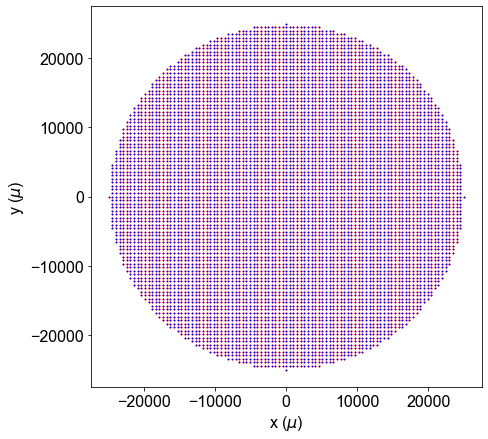

(0.0023484525925647217, 0.5894772998419554)

In [227]:
#select a die from virtual wafer
xspan = 300000
yspan = 300000#yspan_arr[itr_idx]
origin = [0,0]#origin_arr[itr_idx]
tot_hx_arr = []
tot_hy_arr = []
all_dh = []
for i in range(len(tot_hx_array)):
    temp_x = tot_hx_array[i]
    temp_y = tot_hy_array[i]
    if(temp_x >= origin[0]-(xspan/2) and temp_x< origin[0]+(xspan/2)):
        if(temp_y >= origin[1]-(yspan/2) and temp_y< origin[1]+(yspan/2)):
            tot_hx_arr.append(temp_x)
            tot_hy_arr.append(temp_y)
            all_dh.append(tot_dh[i])
np.mean(all_dh), np.std(all_dh)

#PLOT POINTS
fig = plt.figure()
plt.plot(tot_hx_array, tot_hy_array, 'ro', markersize = 1)
plt.plot(tot_hx_arr, tot_hy_arr, 'bx', markersize = 1)
fig.set_size_inches(7,7)
plt.xlabel(r'x ($\mu$)')
plt.ylabel(r'y ($\mu$)')
plt.show()


np.mean(all_dh), np.std(all_dh)

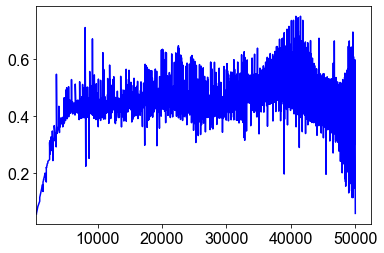

In [228]:
#for each pair generate absolute difference between heights

rh_pair = [[], []]
count = 0
for i in tqdm_notebook(range(len(tot_hx_arr))):
    for j in range(i+1,len(tot_hx_arr),1):
        e = np.sqrt((tot_hx_arr[i] - tot_hx_arr[j])**2 + (tot_hy_arr[i] - tot_hy_arr[j])**2)        
        #rh = np.sqrt((all_dh[i] - all_dh[j])**2)
        rh = abs(all_dh[i]**2 - all_dh[j]**2)
    
        rh_pair[0].append(e)
        rh_pair[1].append(rh)
        
bin_size = 1

#generate limits as arrays
ranges = []
for max_limit in range(0, int(max(rh_pair[0])), bin_size):
    ranges.append([max_limit, max_limit+bin_size,  [], []])

avg_h = [[], []]



#n times add them in the appropriate dictionaries
for i in tqdm_notebook(range(len(rh_pair[0]))):
    each_val = rh_pair[0][i]
    #print(i, len(rh_pair[0]))
    #binary search to find the best match
    left = 0
    right = len(ranges)-1
    while True:
        arr_idx = int(round((left+right)/2))
        if(each_val >= ranges[arr_idx][0] and each_val < ranges[arr_idx][1]):
            break
            
        else:
            if(each_val < ranges[arr_idx][0]):
                if(arr_idx > 0):
                    right = arr_idx -1
                else:
                    break
            elif(each_val >= ranges[arr_idx][1]):
                if(arr_idx < len(ranges)-1):
                    left = arr_idx + 1
                else:
                    break
                    
    ranges[arr_idx][2].append(rh_pair[1][i])
    ranges[arr_idx][3].append(rh_pair[0][i])

    
for i in range(len(ranges)):
        if(len(ranges[i][2])>0):
            avg_h[0].append(np.mean(ranges[i][3]))
            avg_h[1].append(np.mean(ranges[i][2]))
        
#print(max(avg_h))
plt.plot(avg_h[0], avg_h[1], 'b')
#plt.plot([cl,cl], [min(avg_h[1]),max(avg_h[1])], 'y')
#plt.plot(avg_h[0], avg_h_median, 'r',alpha=0.2)
plt.xlim(left = min(avg_h[0]))

plt.show()




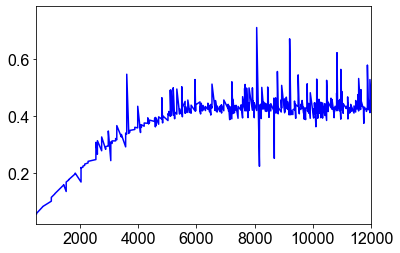

In [231]:
plt.plot(avg_h[0], avg_h[1], 'b')
#plt.plot([cl,cl], [min(avg_h[1]),max(avg_h[1])], 'y')
#plt.plot(avg_h[0], avg_h_median, 'r',alpha=0.2)
plt.xlim(left = min(avg_h[0]),right=12000)

plt.show()


Parameters [ 5.13790058  0.22703203 -0.20877873]
RMSE: 0.0571968663465233
R-squared: 0.9264924574847531
DIV 348


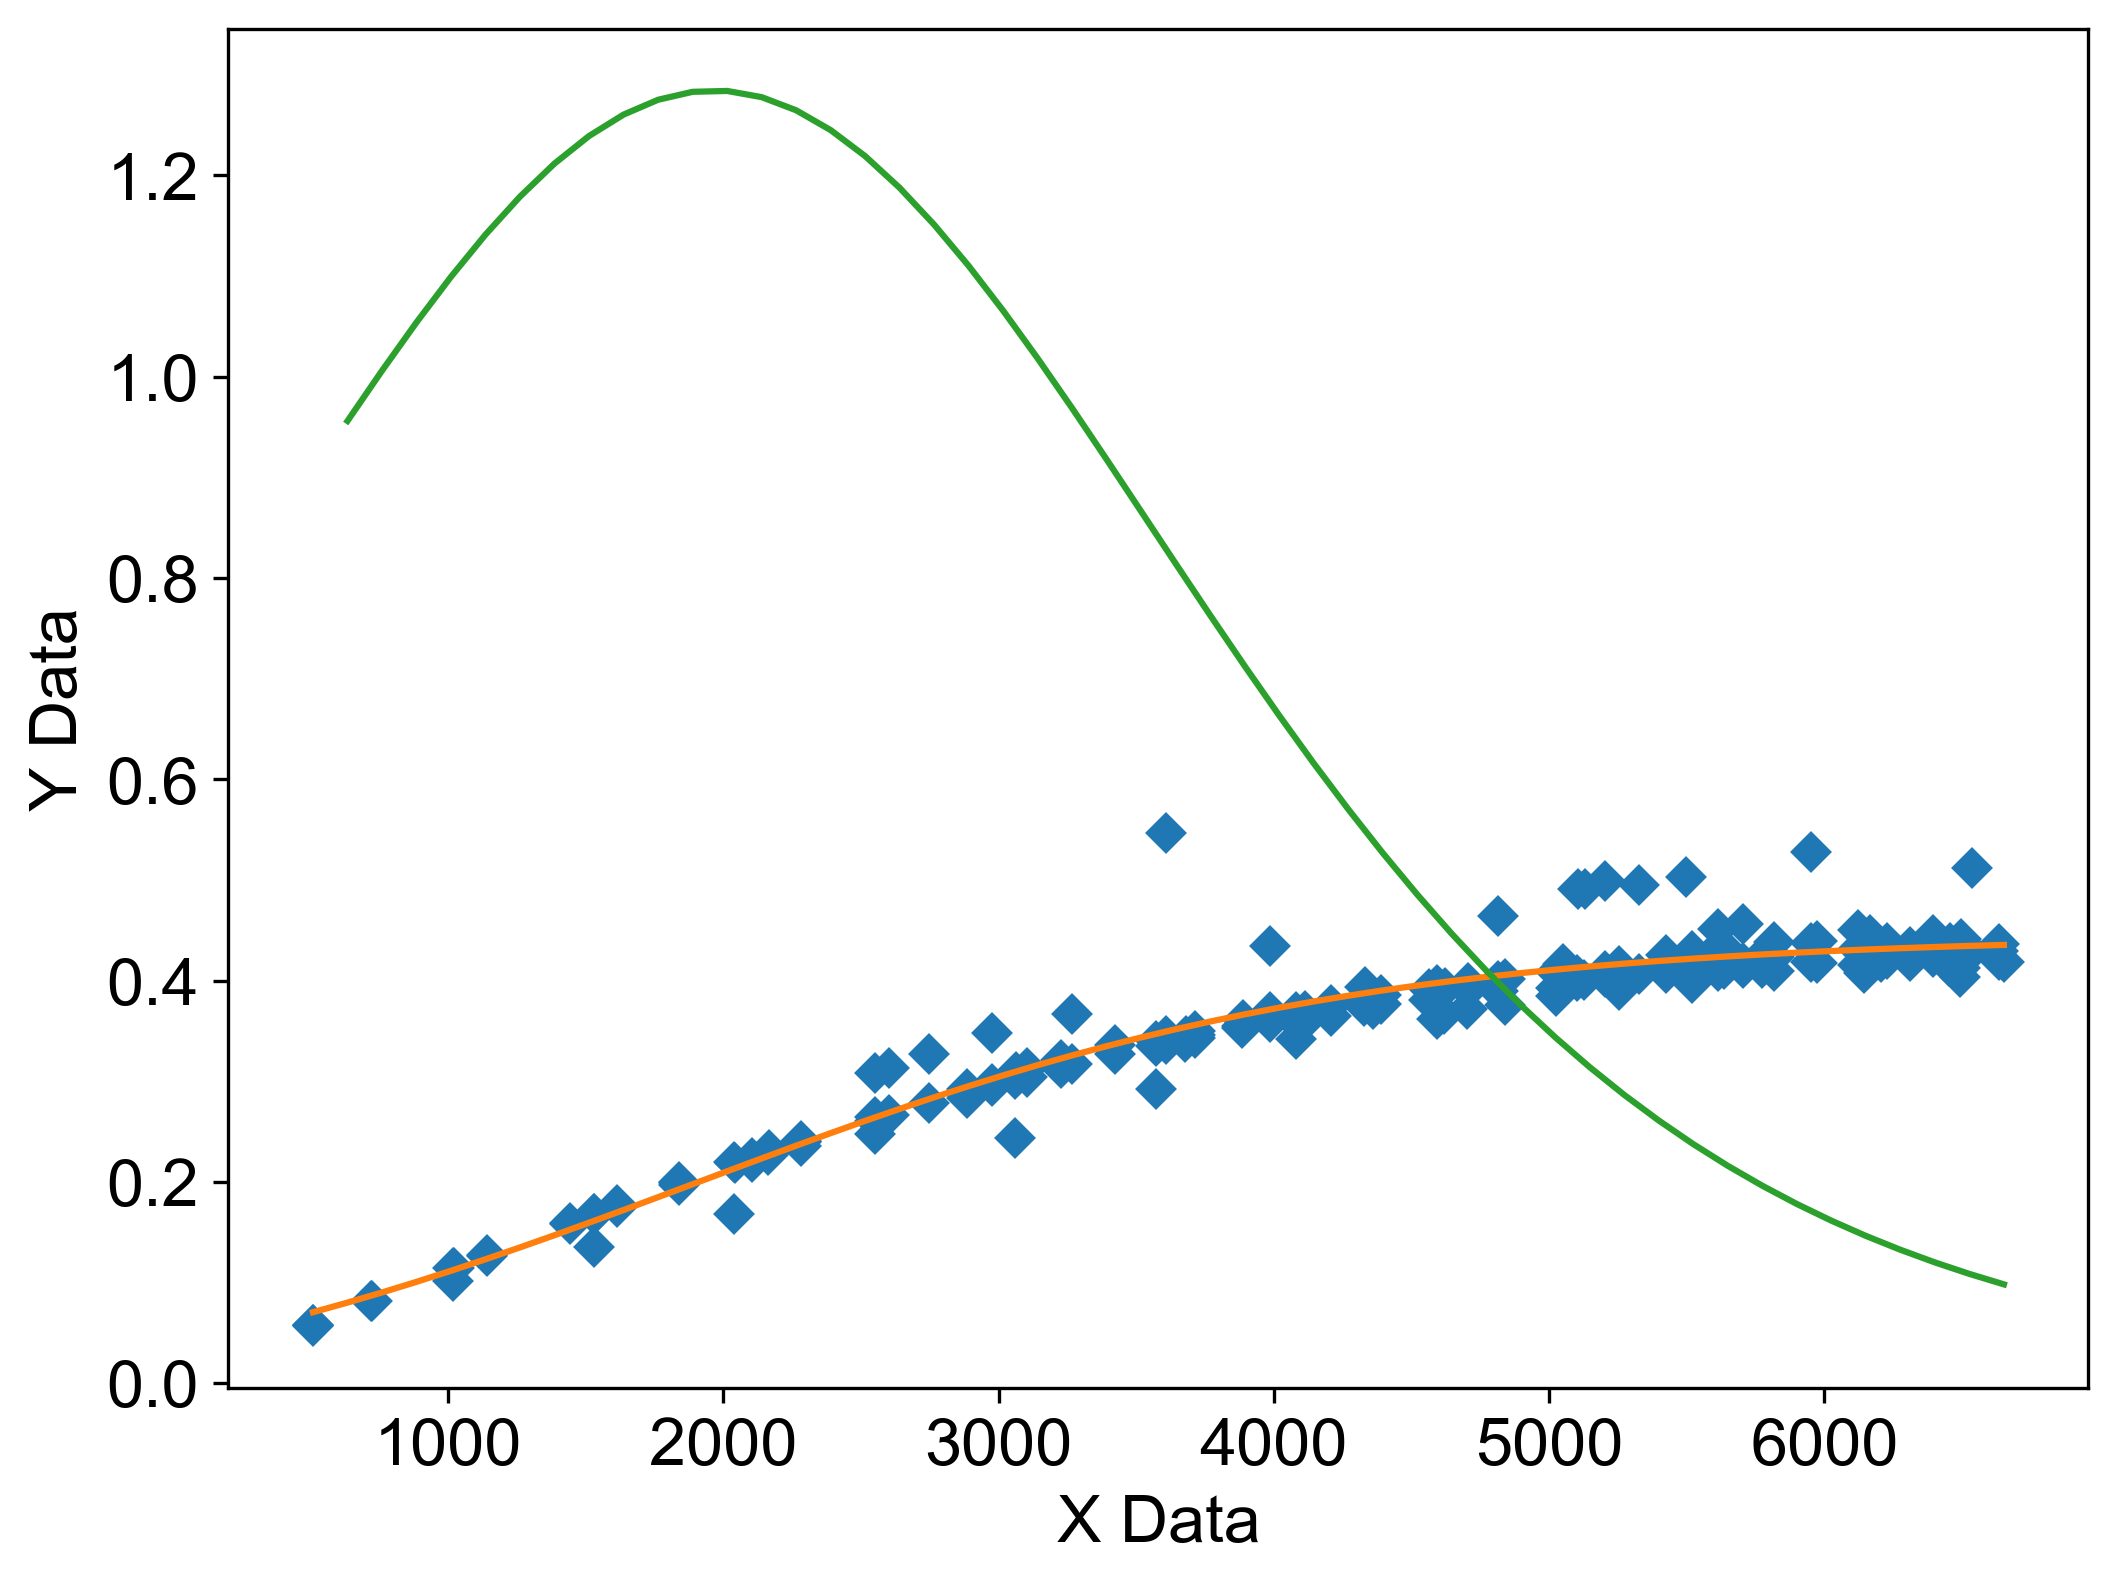


0.9 = 4440.106818736549 , 0.925 = 4744.837845565276 , 0.95 = 5134.524188964436 , 0.975 = 5683.040037256144 , 
1 = 6172.456534890161 , 


In [232]:
#you might have to tweak the tolerance and range to get better estimations

import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

graphWidth = 800
graphHeight = 600

##########################################################
# graphics output section
def ModelAndScatterPlot(xData, yData, xscale, yscale, graphWidth, graphHeight, plot='y'):


    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)
    
    ydiff = np.diff(yModel)/np.diff(xModel)
    if(np.argmin(ydiff>=0.1)>0): #TOLERANCE
        fit = 1
    else:
        fit = 0
    if(plot=='y'):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
        axes = f.add_subplot(111)
        #xData = xData*xscale
        #yData=  yData*yscale
        # first the raw data as a scatter plot
        axes.plot((xData*(xscale[1]-xscale[0])) + xscale[0], (yData*(yscale[1]-yscale[0])) + yscale[0],  'D')    
        # now the model as a line plot
        axes.plot((xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0])
        axes.plot((xModel[1:]*(xscale[1]-xscale[0])) + xscale[0], ydiff)

        axes.set_xlabel('X Data') # X axis data label
        axes.set_ylabel('Y Data') # Y axis data label

        plt.show()
        plt.close('all') # clean up after using pyplot
    
    return (xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0], fit


def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # seach bounds for a
    parameterBounds.append([minX, maxX]) # seach bounds for b
    parameterBounds.append([minX, maxY]) # seach bounds for Offset

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x
    
rsquared_arr = []
div_arr = []


for div in tqdm_notebook(range(1,1000,1)): #RANGE
    divisor = div/10
    xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
    #normalize
    max_x = max(xData)
    min_x = min(xData)
    
    xData = (xData - min_x)/(max_x - min_x)

    yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
    max_y = max(yData)
    min_y = min(yData)
    #scaley = max(yData)
    yData = (yData - min_y)/(max_y - min_y)



    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters()

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

    #print('Parameters', fittedParameters)

    modelPredictions = func(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
    xfit, yfit, tempfit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], graphWidth, graphHeight, 'n')
    if(tempfit ==1):
        rsquared_arr.append(Rsquared)
        div_arr.append(div)
        #print('RMSE:', RMSE)
        #print('R-squared:', Rsquared)
    #print()
    #xfit, yfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)

#idx = len(rsquared_arr)-1#rsquared_arr.index(max(rsquared_arr))
div = div_arr[-1]
divisor = div/10
xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
#normalize
max_x = max(xData)
min_x = min(xData)

xData = (xData - min_x)/(max_x - min_x)

yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
max_y = max(yData)
min_y = min(yData)
#scaley = max(yData)
yData = (yData - min_y)/(max_y - min_y)


# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)
print('DIV', div)
rsquared_arr.append(Rsquared)
div_arr.append(div)
xofit, yofit, fit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], graphWidth, graphHeight)


xfit = (xData*(max_x - min_x)) + min_x
yfit = (modelPredictions*(max_y - min_y)) + min_y

func = interpolate.interp1d(xfit, yfit)
xnew = np.linspace(min(xfit), max(xfit), max(xfit)+1)
ynew = func(xnew)
#plt.plot(xnew, ynew,'b')
maxz_idx = np.argmax(ynew > 0.9 * max(ynew))

#print(xnew[maxz_idx])
print('')
print(0.9, '=',xnew[np.argmax(ynew > 0.9 * max(ynew))],', ', end='')
print(0.925, '=', xnew[np.argmax(ynew > 0.925 * max(ynew))], ', ', end='')
print(0.95, '=',  xnew[np.argmax(ynew > 0.95 * max(ynew))], ', ', end= '')
print(0.975, '=', xnew[np.argmax(ynew > 0.975 * max(ynew))], ', ')
print(1, '=', xnew[np.argmax(ynew >= 0.99 * max(ynew))], ', ')

In [233]:
print(1, '=', xnew[np.argmax(ynew >= 0.99 * max(ynew))], ', ')

1 = 6172.456534890161 , 


In [185]:
xx = []
xy = []

for each in ranges:
    if(len(each[2])>0):
        xx.append(np.mean(each[3]))
        xy.append(len(each[2])/np.sum(each[2]))


0.0602798134006499 3609.0730111761386


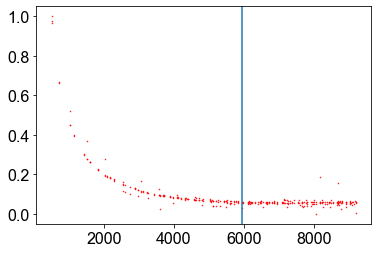

In [186]:
sel_range = 300
sel_xy = np.array(xy[0:sel_range])
sel_xy = (np.array(sel_xy)-min(sel_xy))/(max(sel_xy)-min(sel_xy))
#print(len(sel_xy))

plt.scatter(xx[0:sel_range],sel_xy, color= 'r', s=0.25)
#plt.scatter(avg_h[0], 2*np.array(avg_h[1]), color='b', s=0.25)
plt.axvline(x=cl)
print(sel_xy[np.argmax(np.array(xx)>=cl)], xx[np.argmax(np.array(sel_xy)<=0.04)])

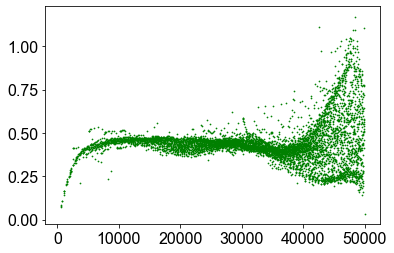

In [136]:
#np.save('avg_curve_data', avg_h)
#wafer_avg = avg_h
#load_avg = np.load('avg_curve_data.npy')


#plt.scatter(wafer_avg[0], wafer_avg[1],color='b', s=0.5)
#plt.scatter(load_avg[0], load_avg[1],color='r',s=0.5)
plt.scatter(avg_h[0], avg_h[1],color='g',s=0.5)

In [ ]:
avg_h[0][int(len(avg_h[0])/18)]
#avg_h = np.load('avg_curve_data.npy')

Parameters [ 4.24691786  0.33097092 -0.12574342]
RMSE: 0.05056703279883682
R-squared: 0.9359961274982016
DIV 500


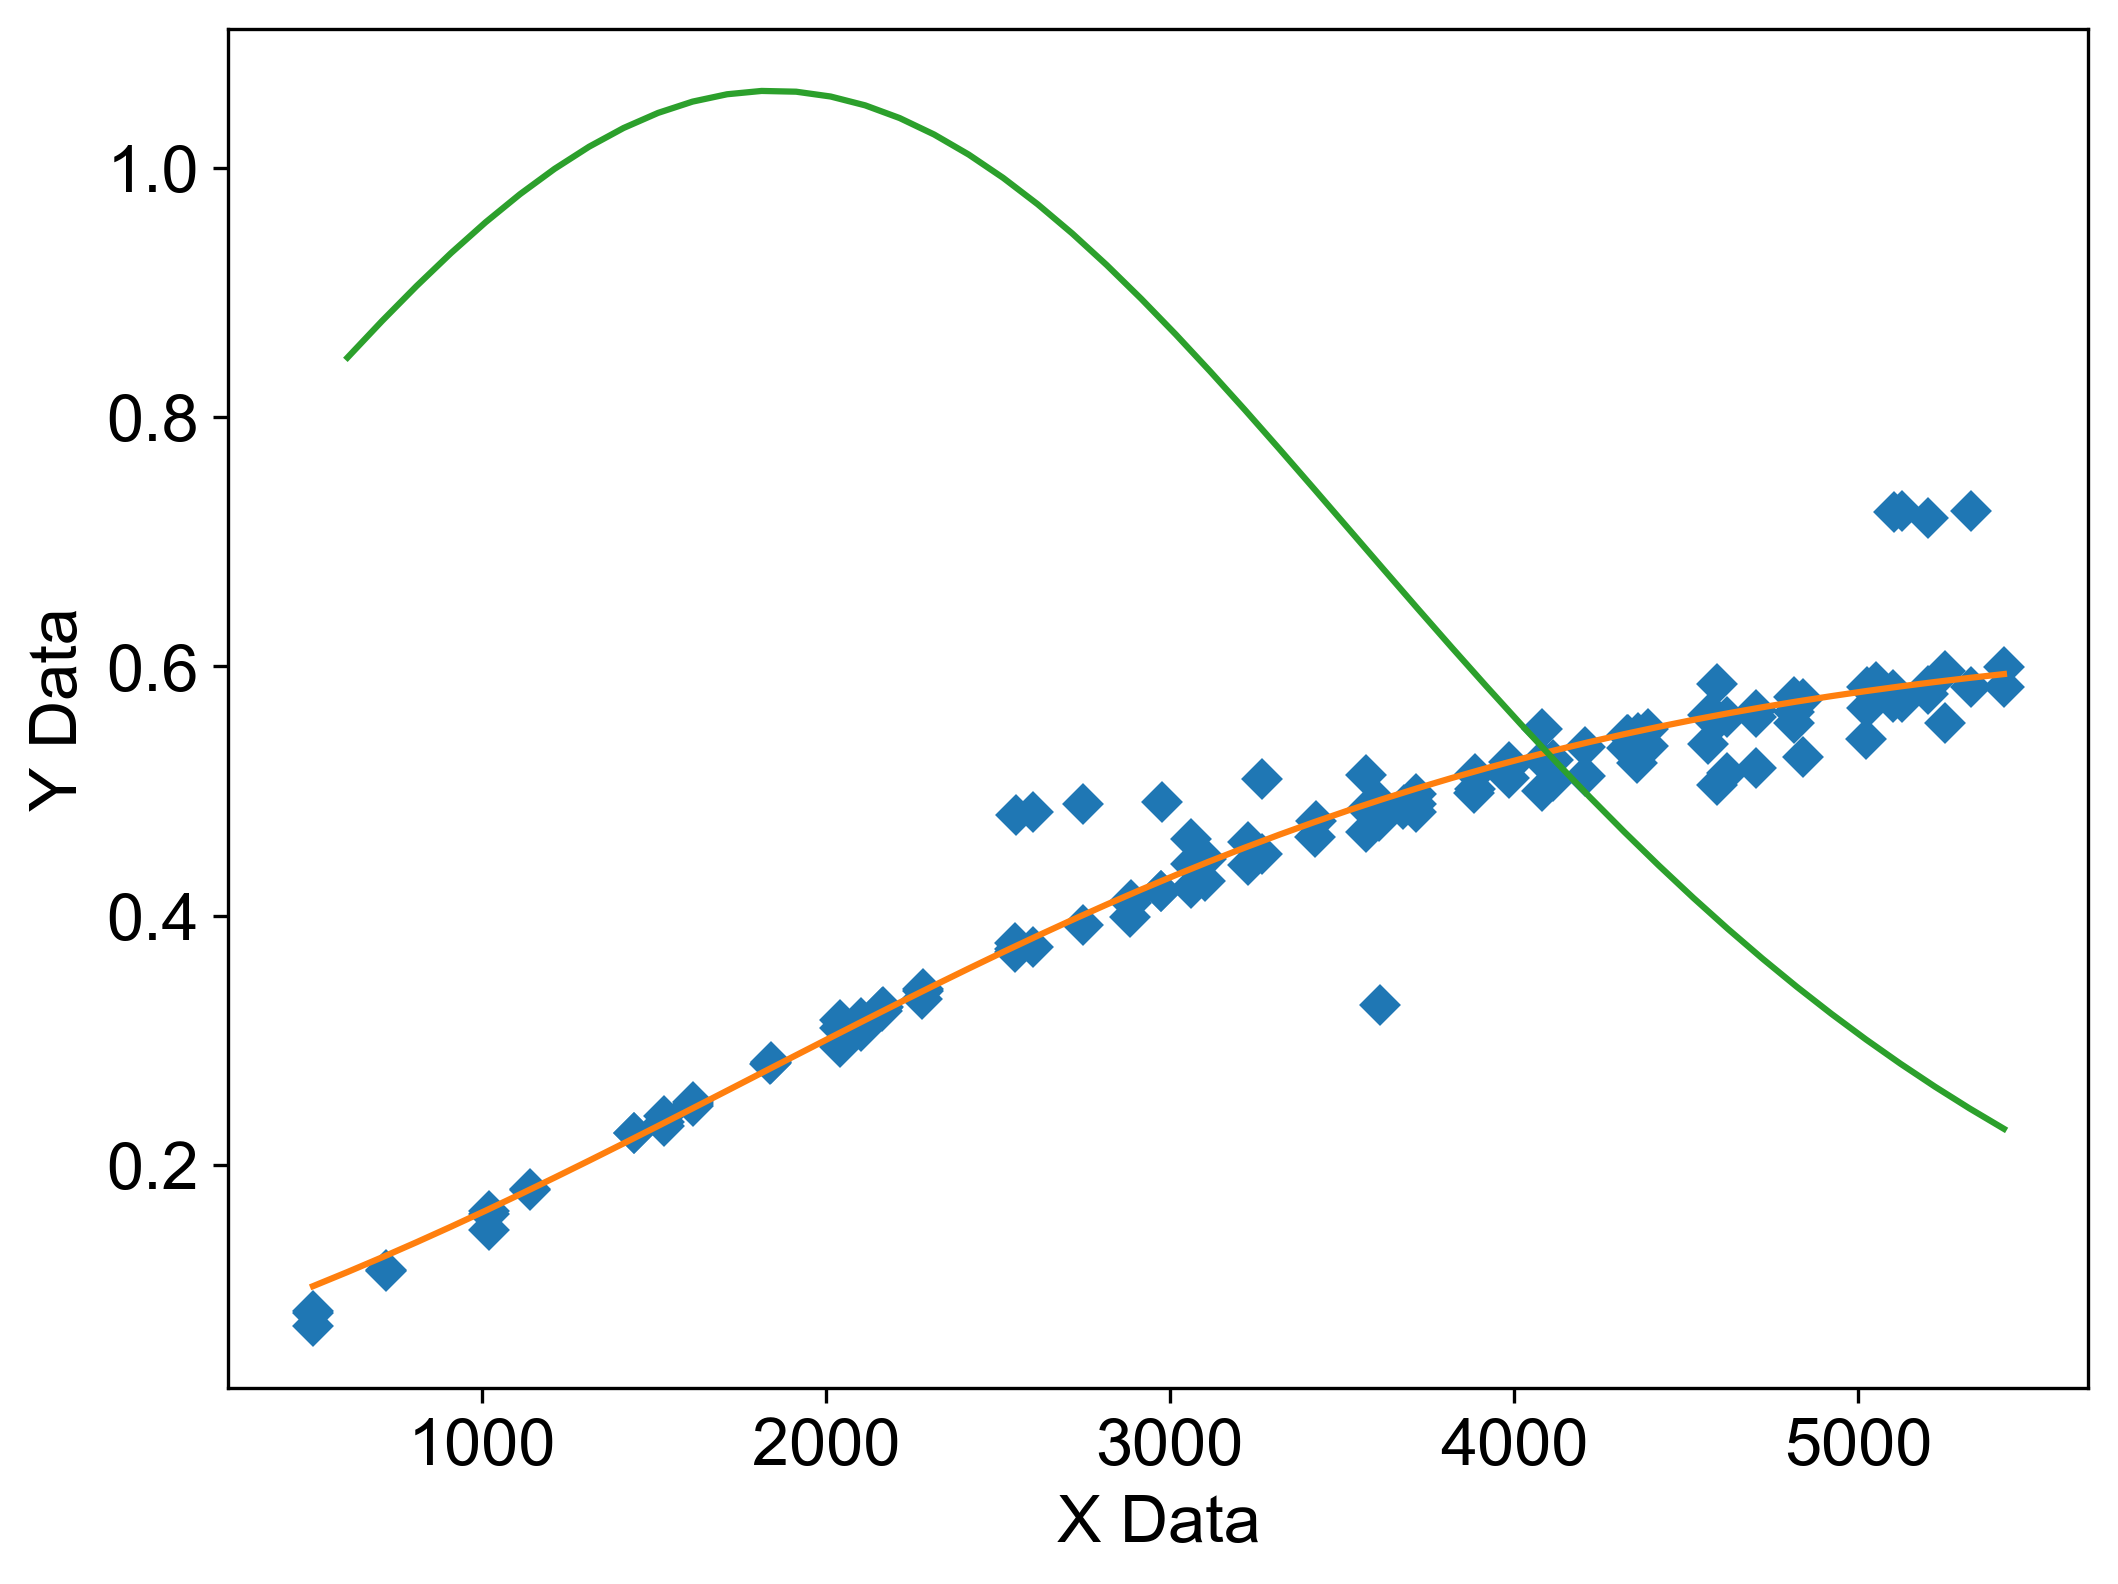


0.9 = 4145.978871582005 , 0.925 = 4381.551885938177 , 0.95 = 4658.803202834289 , 0.975 = 4994.041723264227 , 


In [101]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
from tqdm import tqdm, tqdm_notebook

graphWidth = 800
graphHeight = 600

##########################################################
# graphics output section
def ModelAndScatterPlot(xData, yData, xscale, yscale, graphWidth, graphHeight, plot='y'):


    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)
    
    ydiff = np.diff(yModel)/np.diff(xModel)
    if(np.argmin(ydiff>=0.25)>0):
        fit = 1
    else:
        fit = 0
    if(plot=='y'):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
        axes = f.add_subplot(111)
        #xData = xData*xscale
        #yData=  yData*yscale
        # first the raw data as a scatter plot
        axes.plot(xData*xscale, yData*yscale,  'D')    
        # now the model as a line plot
        axes.plot(xModel*xscale, yModel*yscale)
        axes.plot(xModel[1:]*xscale, ydiff)

        axes.set_xlabel('X Data') # X axis data label
        axes.set_ylabel('Y Data') # Y axis data label

        plt.show()
        plt.close('all') # clean up after using pyplot
    
    return xModel*xscale, yModel*yscale, fit


def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # seach bounds for a
    parameterBounds.append([minX, maxX]) # seach bounds for b
    parameterBounds.append([minX, maxY]) # seach bounds for Offset

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x
    
rsquared_arr = []
div_arr = []


for div in tqdm_notebook(range(1,501,1)):
    divisor = div/10
    xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
    scalex = max(xData)
    xData = xData/scalex

    yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
    scaley = max(yData)
    yData = yData/scaley



    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters()

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

    #print('Parameters', fittedParameters)

    modelPredictions = func(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
    xfit, yfit, tempfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight, 'n')
    if(tempfit ==1):
        rsquared_arr.append(Rsquared)
        div_arr.append(div)
        #print('RMSE:', RMSE)
        #print('R-squared:', Rsquared)
    #print()
    #xfit, yfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)

#idx = len(rsquared_arr)-1#
#idx = rsquared_arr.index(max(rsquared_arr))
div = div_arr[-1]
divisor = div/10
xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
scalex = max(xData)
xData = xData/scalex
yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
scaley = max(yData)
yData = yData/scaley



# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)
print('DIV', div)
rsquared_arr.append(Rsquared)
div_arr.append(div)
xofit, yofit, fit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)
xfit = xData*scalex
yfit = modelPredictions*scaley

func = interpolate.interp1d(xfit, yfit)
xnew = np.linspace(min(xfit), max(xfit), max(xfit)+1)
ynew = func(xnew)
#plt.plot(xnew, ynew,'b')
maxz_idx = np.argmax(ynew > 0.9 * max(ynew))

#print(xnew[maxz_idx])
print('')
print(0.9, '=',xnew[np.argmax(ynew > 0.9 * max(ynew))],', ', end='')
print(0.925, '=', xnew[np.argmax(ynew > 0.925 * max(ynew))], ', ', end='')
print(0.95, '=',  xnew[np.argmax(ynew > 0.95 * max(ynew))], ', ', end= '')
print(0.975, '=', xnew[np.argmax(ynew > 0.975 * max(ynew))], ', ')

In [170]:
xnew[np.argmax(ynew >= 0.99 * max(ynew))]

5953.773464038594